# 1 source and target space

Using device: cuda


/tmp/ipykernel_4001044/1537593587.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


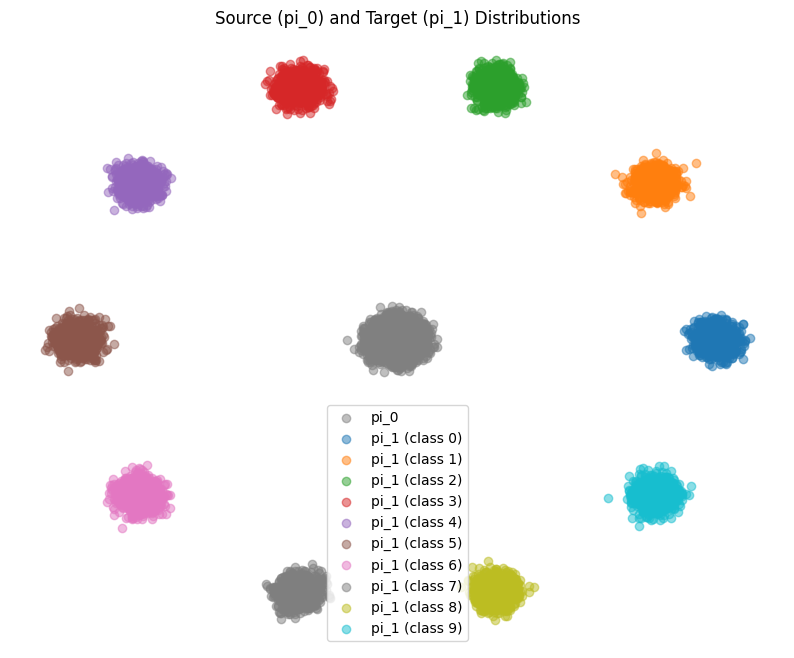

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
from copy import deepcopy

# Set seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
set_seed(0)

# Function to sample from a multimodal distribution
def sample_multimodal_distribution(modes, std, num_samples_per_mode=1000):
    dataset = []
    for i in range(modes.shape[0]):
        for _ in range(num_samples_per_mode):
            sample = np.random.randn(modes.shape[1]) * std
            sample[0] += modes[i, 0]
            sample[1] += modes[i, 1]
            instance = np.concatenate((sample, np.array([i])))
            dataset.append(instance)
    return np.array(dataset, dtype="float32")

# Create Source & Target Distributions for 10 classes
num_classes = 10
dataset_size = 10000
std = 0.5
radius = 15.0

# pi_1 distributions in a circle
theta_1 = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)
modes_1 = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta_1), np.sin(theta_1))])
pi_1 = sample_multimodal_distribution(modes_1, std, num_samples_per_mode=dataset_size // num_classes)

# pi_0 distribution at the center
modes_0 = np.array([[0, 0]])
pi_0 = sample_multimodal_distribution(modes_0, std, num_samples_per_mode=dataset_size)
# Assign classes to pi_0 samples for visualization, will be ignored in training
pi_0[:, 2] = np.random.randint(0, num_classes, dataset_size)

# Create a color map for the 10 classes
colors = plt.cm.get_cmap('tab10', num_classes)

# Plot the initial distributions
plt.figure(figsize=(10, 8))
plt.scatter(pi_0[:, 0], pi_0[:, 1], color="gray", alpha=0.5, marker="o", label="pi_0")
for i in range(num_classes):
    plt.scatter(pi_1[pi_1[:, 2] == i, 0], pi_1[pi_1[:, 2] == i, 1], color=colors(i), alpha=0.5, marker="o", label=f"pi_1 (class {i})")
plt.title("Source (pi_0) and Target (pi_1) Distributions")
plt.legend()
plt.axis('off')
plt.show()

In [2]:
class MLPWithClassifier(nn.Module):
    def __init__(self, num_classes, in_dim, context_dim, h, out_dim):
        super(MLPWithClassifier, self).__init__()
        self.embedding_table = nn.Embedding(num_classes, in_dim + context_dim)
        self.embedding_table.weight.data.normal_(0, 1)
        
        # Flow matching network
        self.network = nn.Sequential(
            nn.Linear(in_dim + context_dim, h),
            nn.Tanh(),
            nn.Linear(h, h),
            nn.Tanh(),
        )
        
        # Flow prediction head
        self.flow_head = nn.Linear(h, out_dim)
        
        # Classification head
        self.classifier_head = nn.Linear(h, num_classes)

    def forward(self, x, context, target_class):
        class_embedding = self.embedding_table(target_class)
        x_t = torch.cat((x, context), dim=1)
        x_t_by_c = x_t + class_embedding
        
        hidden = self.network(x_t_by_c)
        
        flow_pred = self.flow_head(hidden)
        class_pred = self.classifier_head(hidden)
        
        return flow_pred, class_pred

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2):
        self.dist1 = dist1
        self.dist2 = dist2
        # Ensure target distribution has more or equal samples than source
        assert self.dist1.shape[0] <= self.dist2.shape[0]

    def __len__(self):
        return self.dist1.shape[0]

    def __getitem__(self, idx):
        # Each source sample is paired with a target sample from the corresponding class
        target_class = int(self.dist2[idx % self.dist2.shape[0], 2])
        return self.dist1[idx], self.dist2[idx]

# Shuffle pi_1 to ensure random pairing in the dataset
np.random.shuffle(pi_1)
dataset = Dataset(pi_0, pi_1)
train_dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

In [4]:
def train_rectified_flow_with_classifier(
    model, optimizer, 
    train_dataloader, NB_EPOCHS, 
    classification_lambda=1.0, # Weight for the classification loss
    contrastive_obj=False, 
    contrastive_lambda=0.5
):
    flow_losses = []
    class_losses = []
    accuracies = []
    
    criterion_class = nn.CrossEntropyLoss()
    
    for epoch in tqdm(range(NB_EPOCHS)):
        for z0_, z1c in train_dataloader:
            z0_, z1c = z0_.to(device), z1c.to(device)
            t = torch.rand((z1c.shape[0], 1), device=device)
            
            z0 = z0_[:, :2] # remove dummy class index
            z1 = z1c[:, :2] # remove class index
            target_class = z1c[:, 2].long()
            
            z_t = t * z1 + (1. - t) * z0
            target = z1 - z0
            
            flow_pred, class_pred = model(z_t, t, target_class)
            
            # Flow matching loss
            loss_flow = (target - flow_pred).view(flow_pred.shape[0], -1).pow(2).sum(dim=1).mean()
            
            if contrastive_obj:
                negative_idx = torch.randperm(flow_pred.shape[0])
                negatives = target[negative_idx]
                loss_flow = loss_flow - (negatives - flow_pred).view(flow_pred.shape[0], -1).pow(2).sum(dim=1).mean() * contrastive_lambda
            
            # Classification loss
            loss_class = criterion_class(class_pred, target_class)
            
            # Total loss
            loss = loss_flow + classification_lambda * loss_class
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(class_pred.data, 1)
            accuracy = (predicted == target_class).sum().item() / target_class.size(0)
            
        flow_losses.append(loss_flow.item())
        class_losses.append(loss_class.item())
        accuracies.append(accuracy)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Flow Loss: {loss_flow.item():.4f}, Class Loss: {loss_class.item():.4f}, Accuracy: {accuracy:.4f}")

# Train the model
cfm_classifier_model = MLPWithClassifier(num_classes=num_classes, in_dim=2, context_dim=1, h=128, out_dim=2).to(device)
optimizer = torch.optim.Adam(cfm_classifier_model.parameters(), lr=1e-3, weight_decay=0.01)
train_rectified_flow_with_classifier(cfm_classifier_model, optimizer, train_dataloader, NB_EPOCHS=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<02:21,  7.05it/s]

Epoch 0: Flow Loss: 192.7323, Class Loss: 2.0909, Accuracy: 0.3081


 10%|█         | 105/1000 [00:04<00:38, 23.50it/s]

Epoch 100: Flow Loss: 8.0840, Class Loss: 0.1328, Accuracy: 0.9563


 20%|██        | 204/1000 [00:09<00:32, 24.23it/s]

Epoch 200: Flow Loss: 2.1798, Class Loss: 0.0398, Accuracy: 0.9978


 30%|███       | 303/1000 [00:13<00:29, 23.35it/s]

Epoch 300: Flow Loss: 1.6085, Class Loss: 0.0349, Accuracy: 0.9978


 40%|████      | 405/1000 [00:18<00:24, 24.32it/s]

Epoch 400: Flow Loss: 1.3295, Class Loss: 0.0323, Accuracy: 0.9989


 50%|█████     | 504/1000 [00:22<00:21, 22.81it/s]

Epoch 500: Flow Loss: 1.2368, Class Loss: 0.0333, Accuracy: 1.0000


 60%|██████    | 603/1000 [00:26<00:16, 24.22it/s]

Epoch 600: Flow Loss: 1.1766, Class Loss: 0.0358, Accuracy: 0.9989


 70%|███████   | 705/1000 [00:31<00:12, 23.25it/s]

Epoch 700: Flow Loss: 1.1143, Class Loss: 0.0354, Accuracy: 1.0000


 80%|████████  | 804/1000 [00:35<00:08, 24.12it/s]

Epoch 800: Flow Loss: 1.1495, Class Loss: 0.0358, Accuracy: 0.9994


 90%|█████████ | 903/1000 [00:39<00:04, 22.20it/s]

Epoch 900: Flow Loss: 1.0184, Class Loss: 0.0364, Accuracy: 1.0000


100%|██████████| 1000/1000 [00:44<00:00, 22.65it/s]


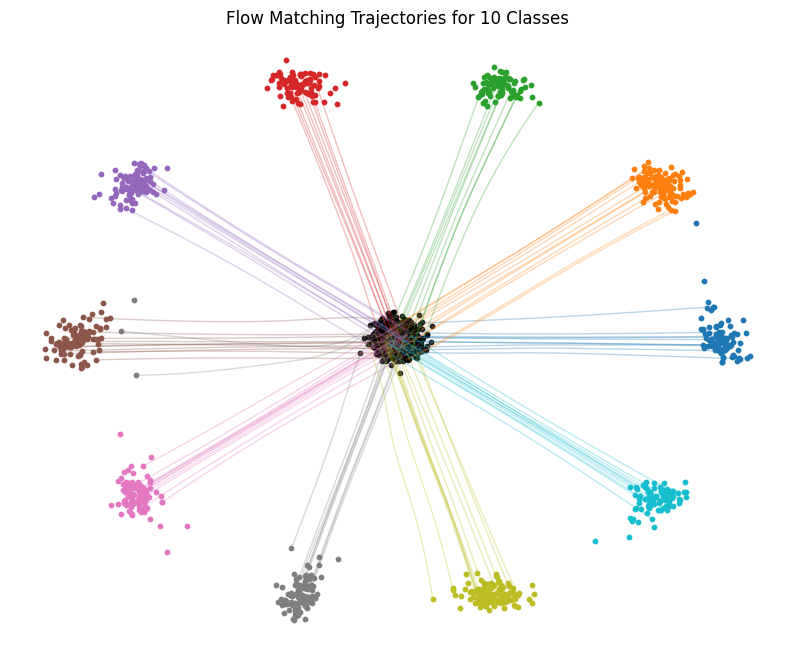

/tmp/ipykernel_4001044/2328827207.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.contourf(xx, yy, Z, cmap=plt.cm.get_cmap('tab10', 10), alpha=0.3)


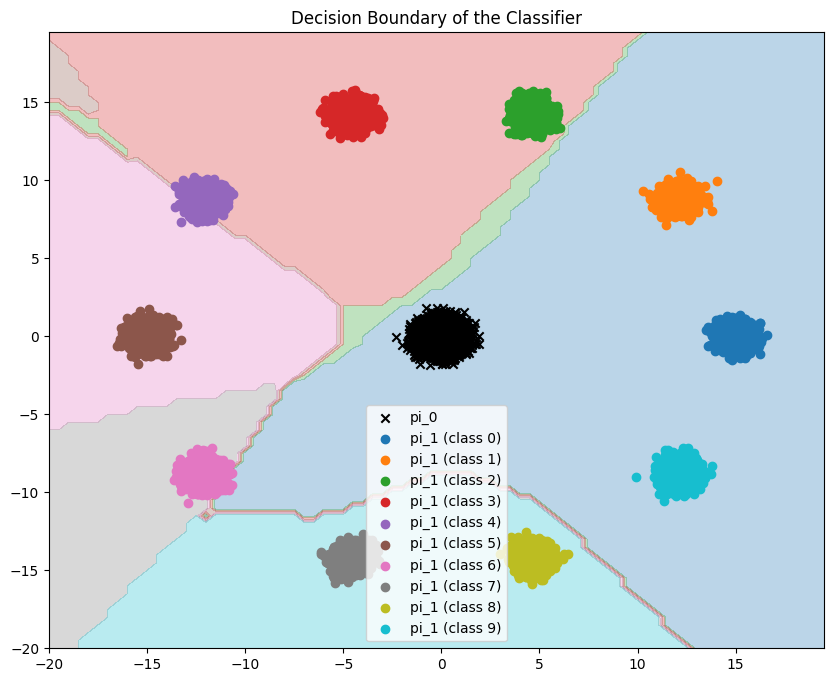

In [5]:
# Create a sampler function
def sample_fn_with_classifier(model, T, pi_0):
    samples = [pi_0.clone().unsqueeze(0)]
    for i in range(T):
        t = torch.ones((pi_0.shape[0], 1), device=samples[-1].device) * i / T
        inp = samples[-1].squeeze(0)
        flow_pred, _ = model(inp[:, :2], t, inp[:, 2].long())
        next_sample = deepcopy(samples[-1].detach())
        next_sample[0, :, :2] = next_sample[0, :, :2] + flow_pred * 1. / T
        samples += [next_sample]
    return torch.cat(samples)

# Create test data
test_pi_0 = sample_multimodal_distribution(modes_0, 0.5, num_samples_per_mode=1000)
test_pi_0[:, 2] = np.random.randint(0, num_classes, 1000)

# Generate flow samples
flow_samples = sample_fn_with_classifier(cfm_classifier_model, 1000, torch.from_numpy(test_pi_0).to(device))
flow_samples_flat = flow_samples.reshape(-1, 3)

# Plot the flow matching results
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    class_samples = flow_samples_flat[flow_samples_flat[:, 2] == i, :2].reshape(1001, -1, 2)
    for sample_idx in range(0, class_samples.shape[1], 10):
        x = class_samples[:, sample_idx, 0].cpu().detach().numpy()
        y = class_samples[:, sample_idx, 1].cpu().detach().numpy()
        plt.plot(x, y, color=colors(i), linewidth=1., alpha=0.3)

plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="black", alpha=0.8, s=10, label="Start (pi_0)")
for i in range(num_classes):
    class_samples_end = flow_samples_flat[flow_samples_flat[:, 2] == i, :2].reshape(1001, -1, 2)[-1]
    plt.scatter(class_samples_end[:, 0].cpu().detach().numpy(), class_samples_end[:, 1].cpu().detach().numpy(), color=colors(i), s=10, label=f"End (class {i})")

plt.title("Flow Matching Trajectories for 10 Classes")
plt.axis('off')
plt.show()

# Plot the decision boundary
plt.figure(figsize=(10, 8))
x_min, x_max = -20, 20
y_min, y_max = -20, 20
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                     np.arange(y_min, y_max, 0.5))

grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

# We need to provide a time and class embedding to the model.
# For decision boundary, we can use t=1 (end of flow) and any class, 
# as we are only interested in the classifier head's output.
# The classifier head is trained to work across all t.
dummy_t = torch.ones(grid_points_tensor.shape[0], 1).to(device)
dummy_class = torch.zeros(grid_points_tensor.shape[0], dtype=torch.long).to(device)

with torch.no_grad():
    _, class_preds = cfm_classifier_model(grid_points_tensor, dummy_t, dummy_class)
    Z = torch.argmax(class_preds, axis=1).cpu().numpy()
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.get_cmap('tab10', 10), alpha=0.3)
plt.scatter(pi_0[:, 0], pi_0[:, 1], c='black', marker='x', label="pi_0")
for i in range(num_classes):
    plt.scatter(pi_1[pi_1[:, 2] == i, 0], pi_1[pi_1[:, 2] == i, 1], color=colors(i), marker='o', label=f"pi_1 (class {i})")
plt.title("Decision Boundary of the Classifier")
plt.legend()
plt.show()

# 2 latent space failure

## data space

Using device: cuda


/tmp/ipykernel_4001044/2907555673.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


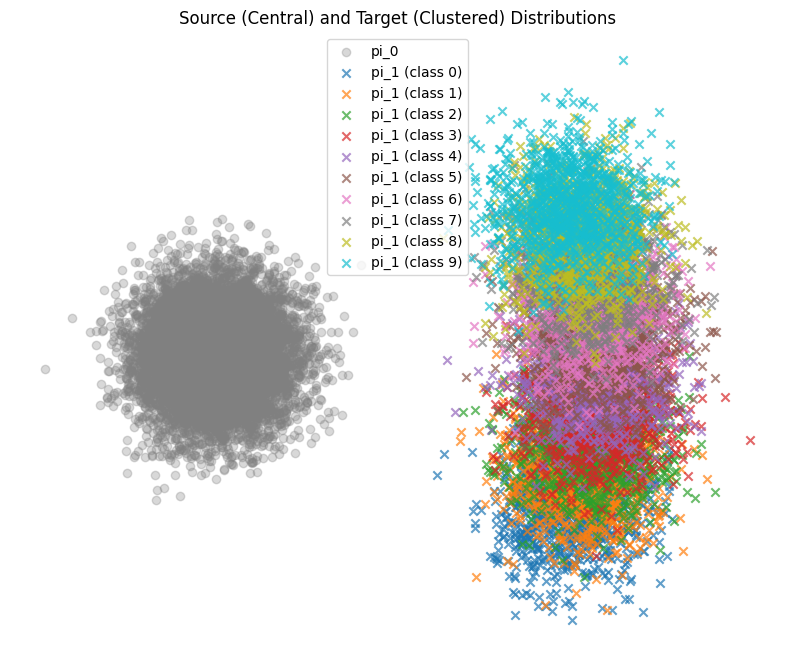

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
from copy import deepcopy

# 为可复现性设置种子
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
set_seed(0)

# 从多模态分布中采样的函数
def sample_multimodal_distribution(modes, std, num_samples_per_mode=1000):
    dataset = []
    num_classes = modes.shape[0]
    for i in range(num_classes):
        for _ in range(num_samples_per_mode):
            sample = np.random.randn(modes.shape[1]) * std
            sample[0] += modes[i, 0]
            sample[1] += modes[i, 1]
            instance = np.concatenate((sample, np.array([i])))
            dataset.append(instance)
    return np.array(dataset, dtype="float32")

# 为10个类别创建源分布和目标分布
num_classes = 10
dataset_size = 10000
std = 0.5

# 1. 源分布 (pi_0): 位于中心的单峰分布
modes_0 = np.array([[0, 0]])
pi_0 = sample_multimodal_distribution(modes_0, std, num_samples_per_mode=dataset_size)
# 在训练中，z0的类别会被忽略，这里仅为数据格式统一
pi_0[:, 2] = np.random.randint(0, num_classes, dataset_size)

# 2. 目标分布 (pi_1): 10个类别全部集中在一个小区域
radius_target_clustered = 5.0
# 将所有模式的角度都限制在一个很小的扇区
theta_target_clustered = np.linspace(-np.pi / 8, np.pi / 8, num_classes) 
modes_target_clustered = np.array([(radius_target_clustered * np.cos(angle), radius_target_clustered * np.sin(angle)) for angle in theta_target_clustered])
pi_1_clustered = sample_multimodal_distribution(modes_target_clustered, std, num_samples_per_mode=dataset_size // num_classes)


# 为10个类别创建颜色映射
colors = plt.cm.get_cmap('tab10', num_classes)

# 绘制初始分布
plt.figure(figsize=(10, 8))
plt.title("Source (Central) and Target (Clustered) Distributions")
plt.scatter(pi_0[:, 0], pi_0[:, 1], color="gray", alpha=0.3, marker="o", label="pi_0")
for i in range(num_classes):
    plt.scatter(pi_1_clustered[pi_1_clustered[:, 2] == i, 0], 
                pi_1_clustered[pi_1_clustered[:, 2] == i, 1], 
                color=colors(i), marker="x", label=f"pi_1 (class {i})", alpha=0.7)

plt.legend()
plt.axis('off')
plt.show()

## model

In [9]:
# 模型与数据集类 (与之前完全相同)
class MLPWithClassifier(nn.Module):
    def __init__(self, num_classes, in_dim, context_dim, h, out_dim):
        super(MLPWithClassifier, self).__init__()
        self.embedding_table = nn.Embedding(num_classes, in_dim + context_dim)
        self.embedding_table.weight.data.normal_(0, 1)
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h), nn.Tanh(), nn.Linear(h, h), nn.Tanh())
        self.flow_head = nn.Linear(h, out_dim)
        self.classifier_head = nn.Linear(h, num_classes)
    def forward(self, x, context, target_class):
        class_embedding = self.embedding_table(target_class)
        x_t = torch.cat((x, context), dim=1)
        x_t_by_c = x_t + class_embedding
        hidden = self.network(x_t_by_c)
        flow_pred, class_pred = self.flow_head(hidden), self.classifier_head(hidden)
        return flow_pred, class_pred

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2):
        self.dist1, self.dist2 = dist1, dist2
        assert self.dist1.shape[0] >= self.dist2.shape[0]
    def __len__(self):
        return self.dist2.shape[0]
    def __getitem__(self, idx):
        return self.dist1[idx % self.dist1.shape[0]], self.dist2[idx]

# 创建新的DataLoader
dataset = Dataset(pi_0, pi_1_clustered)
train_dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

# 训练函数 (与之前完全相同)
def train_rectified_flow_with_classifier(
    model, optimizer, 
    train_dataloader, NB_EPOCHS, 
    classification_lambda=1.0, contrastive_obj=False, contrastive_lambda=0.5
):
    criterion_class = nn.CrossEntropyLoss()
    for epoch in tqdm(range(NB_EPOCHS)):
        for z0_, z1c in train_dataloader:
            z0_, z1c = z0_.to(device), z1c.to(device)
            t = torch.rand((z1c.shape[0], 1), device=device)
            
            z0 = z0_[:, :2]
            z1 = z1c[:, :2]
            target_class = z1c[:, 2].long()
            
            z_t = t * z1 + (1. - t) * z0
            target_flow = z1 - z0
            
            flow_pred, class_pred = model(z_t, t, target_class)
            
            loss_flow = (target_flow - flow_pred).view(flow_pred.shape[0], -1).pow(2).sum(dim=1).mean()
            
            # 启用对比损失
            if contrastive_obj:
                negative_idx = torch.randperm(flow_pred.shape[0])
                negatives = target_flow[negative_idx]
                loss_flow = loss_flow - (negatives - flow_pred).view(flow_pred.shape[0], -1).pow(2).sum(dim=1).mean() * contrastive_lambda

            loss_class = criterion_class(class_pred, target_class)
            loss = loss_flow + classification_lambda * loss_class
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# 训练模型
cfm_contrastive_model = MLPWithClassifier(num_classes=num_classes, in_dim=2, context_dim=1, h=256, out_dim=2).to(device)
optimizer = torch.optim.Adam(cfm_contrastive_model.parameters(), lr=1e-3, weight_decay=0.01)

# *** 关键：启用对比目标 ***
train_rectified_flow_with_classifier(
    cfm_contrastive_model, optimizer, train_dataloader, 
    NB_EPOCHS=2000, 
    contrastive_obj=True, 
    contrastive_lambda=0.5 # 这个超参数控制排斥力的强度
)

100%|██████████| 2000/2000 [01:57<00:00, 16.98it/s]


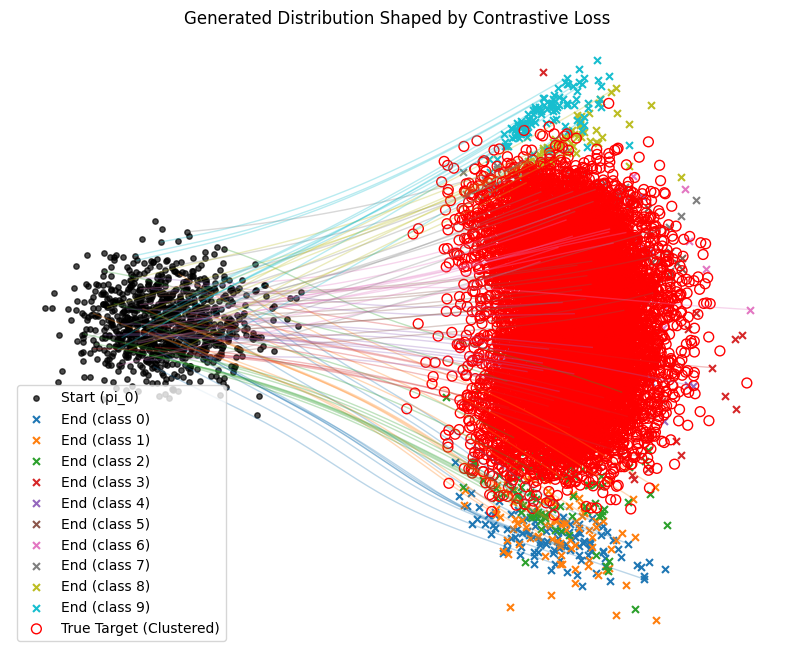

/tmp/ipykernel_4001044/1166847703.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.contourf(xx, yy, Z, cmap=plt.cm.get_cmap('tab10', 10), alpha=0.3)


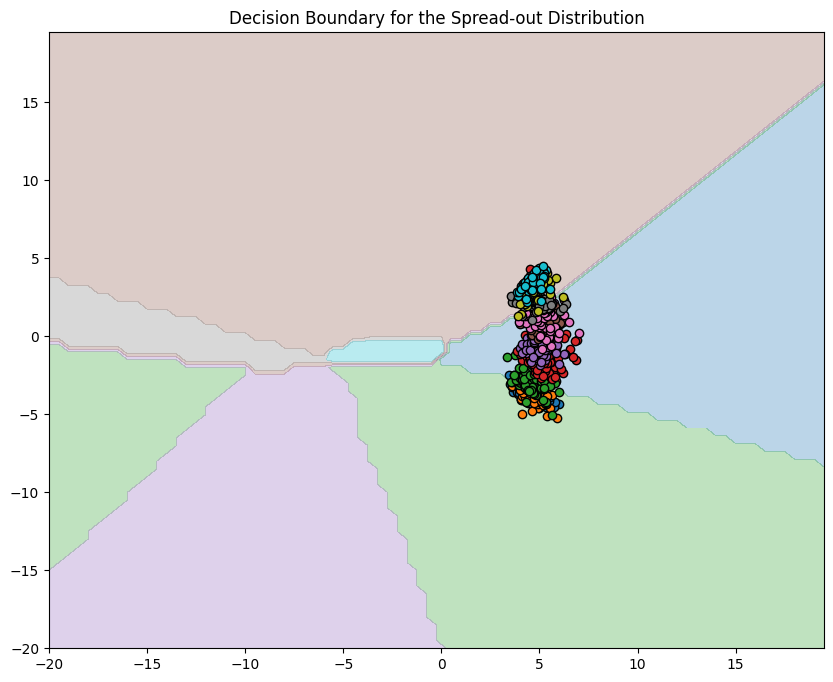

In [10]:
# 采样函数 (与之前相同)
def sample_fn_with_classifier(model, T, pi_0):
    samples = [pi_0.clone().unsqueeze(0)]
    for i in range(T):
        t = torch.ones((pi_0.shape[0], 1), device=samples[-1].device) * i / T
        inp = samples[-1].squeeze(0)
        flow_pred, _ = model(inp[:, :2], t, inp[:, 2].long())
        next_sample = deepcopy(samples[-1].detach())
        next_sample[0, :, :2] = next_sample[0, :, :2] + flow_pred * 1. / T
        samples += [next_sample]
    return torch.cat(samples)

# 使用中心的pi_0作为采样的起点
test_pi_0 = sample_multimodal_distribution(modes_0, 0.5, num_samples_per_mode=1000)
test_pi_0[:, 2] = np.random.randint(0, num_classes, 1000)
test_pi_0_tensor = torch.from_numpy(test_pi_0).to(device)

# 生成流样本
flow_samples = sample_fn_with_classifier(cfm_contrastive_model, 1000, test_pi_0_tensor)

# 绘制流匹配轨迹
plt.figure(figsize=(10, 8))
generated_pi_target = flow_samples[-1].cpu().detach().numpy()

# 绘制轨迹
flow_samples_flat = flow_samples.reshape(-1, 3)
for i in range(num_classes):
    class_samples = flow_samples_flat[flow_samples_flat[:, 2] == i, :2].reshape(1001, -1, 2)
    for sample_idx in range(0, class_samples.shape[1], 10):
        x = class_samples[:, sample_idx, 0].cpu().detach().numpy()
        y = class_samples[:, sample_idx, 1].cpu().detach().numpy()
        plt.plot(x, y, color=colors(i), linewidth=1., alpha=0.3)

# 绘制起点和终点
plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="black", alpha=0.7, s=15, label="Start (pi_0)")
for i in range(num_classes):
    plt.scatter(generated_pi_target[generated_pi_target[:, 2] == i, 0], 
                generated_pi_target[generated_pi_target[:, 2] == i, 1], 
                color=colors(i), marker="x", s=25, label=f"End (class {i})")

# 同时绘制出“真实”的拥挤目标，以作对比
plt.scatter(pi_1_clustered[:, 0], pi_1_clustered[:, 1], edgecolors='red', facecolors='none', s=50, label="True Target (Clustered)")

plt.title("Generated Distribution Shaped by Contrastive Loss")
plt.legend()
plt.axis('off')
plt.show()

# 绘制决策边界
plt.figure(figsize=(10, 8))
x_min, x_max, y_min, y_max = -20, 20, -20, 20
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
dummy_t = torch.ones(grid_points.shape[0], 1).to(device)
dummy_class = torch.zeros(grid_points.shape[0], dtype=torch.long).to(device)

with torch.no_grad():
    _, class_preds = cfm_contrastive_model(grid_points, dummy_t, dummy_class)
    Z = torch.argmax(class_preds, axis=1).cpu().numpy()
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.get_cmap('tab10', 10), alpha=0.3)
# 在决策边界上绘制生成的“优化后”目标点
for i in range(num_classes):
    plt.scatter(generated_pi_target[generated_pi_target[:, 2] == i, 0], 
                generated_pi_target[generated_pi_target[:, 2] == i, 1], 
                color=colors(i), marker="o", edgecolor='black')

plt.title("Decision Boundary for the Spread-out Distribution")
plt.show()

# 3 mapping

In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
from copy import deepcopy

# --- 初始化与数据生成 ---
def set_seed(seed):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(0)

def sample_multimodal_distribution(modes, std, num_samples_per_mode=1000):
    dataset = []
    num_classes = modes.shape[0]
    for i in range(num_classes):
        for _ in range(num_samples_per_mode):
            sample = np.random.randn(modes.shape[1]) * std + modes[i]
            instance = np.concatenate((sample, np.array([i])))
            dataset.append(instance)
    return np.array(dataset, dtype="float32")

num_classes = 10
dataset_size = 10000
std = 0.5

# 1. noise 分布 (z0)
modes_0 = np.array([[0, 0]])
noise_dist = sample_multimodal_distribution(modes_0, std, num_samples_per_mode=dataset_size)
noise_dist[:, 2] = np.random.randint(0, num_classes, dataset_size)

# 2. target_original 分布 (z1_orig)
radius_orig = 5.0
theta_orig = np.linspace(-np.pi / 8, np.pi / 8, num_classes)
modes_orig = np.array([(radius_orig * np.cos(t), radius_orig * np.sin(t)) for t in theta_orig])
target_original_dist = sample_multimodal_distribution(modes_orig, std, num_samples_per_mode=dataset_size // num_classes)

colors = plt.cm.get_cmap('tab10', num_classes)
# --- 数据准备结束 ---

/tmp/ipykernel_4001044/3573643302.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


In [16]:
# FlowNet (与之前的 MLPWithClassifier 相同)
class FlowNet(nn.Module):
    def __init__(self, num_classes, in_dim=2, context_dim=1, h_dim=256, out_dim=2):
        super(FlowNet, self).__init__()
        self.embedding_table = nn.Embedding(num_classes, in_dim + context_dim)
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h_dim), nn.Tanh(), nn.Linear(h_dim, h_dim), nn.Tanh())
        self.flow_head = nn.Linear(h_dim, out_dim)
        self.classifier_head = nn.Linear(h_dim, num_classes)

    def forward(self, x, context, target_class):
        class_embedding = self.embedding_table(target_class)
        x_t = torch.cat((x, context), dim=1)
        x_t_by_c = x_t + class_embedding
        hidden = self.network(x_t_by_c)
        flow_pred, class_pred = self.flow_head(hidden), self.classifier_head(hidden)
        return flow_pred, class_pred


# 新的训练函数，严格按照您的要求实现对比损失
def train_contrastive_cfm(
    flow_net, optimizer,
    train_dataloader, NB_EPOCHS,
    separation_lambda=0.1
):
    criterion_class = nn.CrossEntropyLoss()
    
    for epoch in tqdm(range(NB_EPOCHS), desc="Training with Contrastive Loss"):
        for z0_batch, z1_orig_batch in train_dataloader:
            z0_batch, z1_orig_batch = z0_batch.to(device), z1_orig_batch.to(device)
            
            z0 = z0_batch[:, :2]
            z1_orig = z1_orig_batch[:, :2]
            target_class = z1_orig_batch[:, 2].long()
            
            # 流的目标是z1_orig
            target_flow = z1_orig - z0
            
            t = torch.rand((z0_batch.shape[0], 1), device=device)
            z_t = t * z1_orig + (1. - t) * z0
            
            flow_pred, class_pred = flow_net(z_t, t, target_class)
            
            # a. 标准流匹配损失
            loss_flow_base = (target_flow - flow_pred).pow(2).sum(dim=1).mean()
            
            # b. 对比损失 (排斥力)
            negative_idx = torch.randperm(flow_pred.shape[0])
            negatives = target_flow[negative_idx]
            loss_contrastive = (negatives - flow_pred).pow(2).sum(dim=1).mean()
            
            # c. 分类损失
            loss_class = criterion_class(class_pred, target_class)
            
            # 总损失
            loss = loss_flow_base - separation_lambda * loss_contrastive + loss_class
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- 实例化并开始训练 ---
flow_net = FlowNet(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(flow_net.parameters(), lr=1e-3)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2):
        self.dist1, self.dist2 = dist1, dist2
    def __len__(self): return self.dist1.shape[0]
    def __getitem__(self, idx): return self.dist1[idx], self.dist2[idx % self.dist2.shape[0]]

dataset = Dataset(noise_dist, target_original_dist)
train_dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

train_contrastive_cfm(
    flow_net, optimizer, train_dataloader,
    NB_EPOCHS=3000,
    separation_lambda=0.1 # 控制排斥力的强度
)

Training with Contrastive Loss: 100%|██████████| 3000/3000 [03:51<00:00, 12.95it/s]


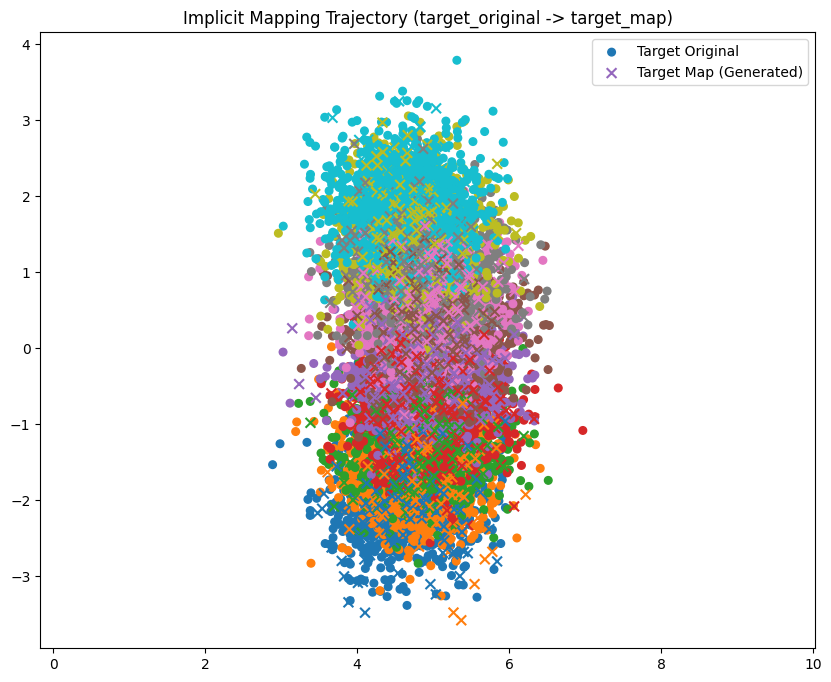

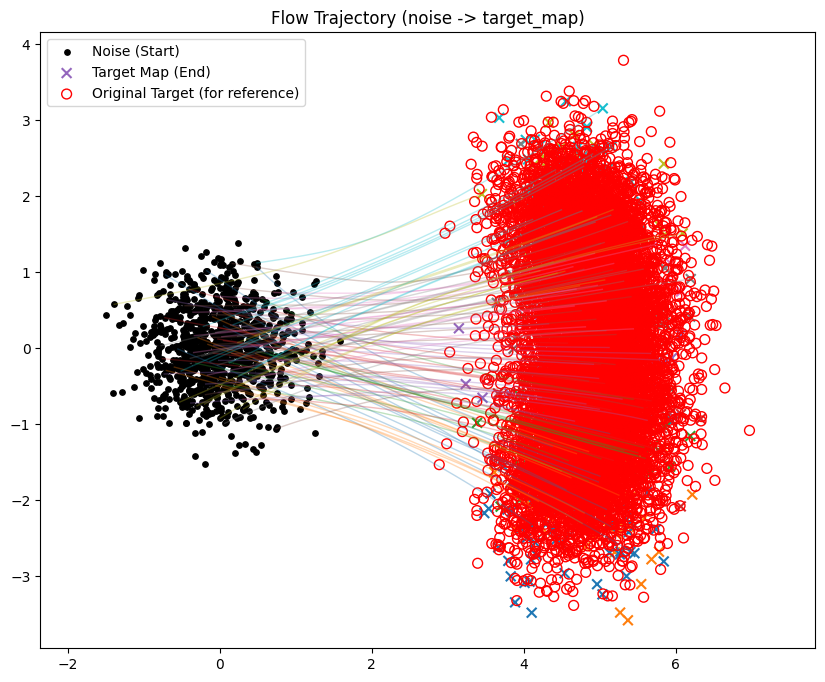

In [17]:
# 采样函数 (与之前相同，但只用一个网络)
def sample_fn(flow_net, T, pi_0_samples):
    samples = [pi_0_samples[:,:2].clone().unsqueeze(0)]
    target_class = pi_0_samples[:,2].long()
    
    for i in range(T):
        t = torch.ones((pi_0_samples.shape[0], 1), device=device) * i / T
        inp_coords = samples[-1].squeeze(0)
        flow_pred, _ = flow_net(inp_coords, t, target_class)
        next_sample = samples[-1].squeeze(0) + flow_pred / T
        samples.append(next_sample.unsqueeze(0))
        
    return torch.cat(samples).cpu().detach()

# --- 准备测试数据 ---
# 我们从noise分布中采样，并赋予它们类别，模拟从不同类别出发的流
test_noise_samples = torch.from_numpy(noise_dist[:1000]).to(device)

# --- 生成流轨迹 ---
flow_trajectories = sample_fn(flow_net, 100, test_noise_samples)

# 最终生成的 target_map
target_map_generated = flow_trajectories[-1].numpy()
noise_np = test_noise_samples.cpu().numpy()
target_original_np = target_original_dist

# --- 1. 绘制“映射”轨迹图 (target_original -> target_map) ---
# 这个映射是隐式学习的，我们通过连接同类别的点来可视化它
plt.figure(figsize=(10, 8))
plt.title("Implicit Mapping Trajectory (target_original -> target_map)")

for i in range(num_classes):
    # 找到原始目标中属于类别i的点
    orig_class_mask = (target_original_np[:, 2] == i)
    # 找到生成目标中属于类别i的点
    gen_class_mask = (noise_np[:, 2] == i)
    
    if not (np.any(orig_class_mask) and np.any(gen_class_mask)): continue
    
    # 取各自的质心来代表映射关系
    orig_centroid = target_original_np[orig_class_mask, :2].mean(axis=0)
    gen_centroid = target_map_generated[gen_class_mask, :2].mean(axis=0)
    
    # 绘制从原始质心到生成质心的箭头
    plt.arrow(orig_centroid[0], orig_centroid[1], 
              gen_centroid[0] - orig_centroid[0], 
              gen_centroid[1] - orig_centroid[1], 
              color=colors(i), alpha=0.8, head_width=0.4, width=0.1, length_includes_head=True)

plt.scatter(target_original_np[:, 0], target_original_np[:, 1], c=target_original_np[:, 2], cmap=colors, marker="o", s=30, label="Target Original")
plt.scatter(target_map_generated[:, 0], target_map_generated[:, 1], c=noise_np[:, 2], cmap=colors, marker="x", s=50, label="Target Map (Generated)")
plt.legend()
plt.axis('equal')
plt.show()


# --- 2. 绘制 Flow 的轨迹图 (noise -> target_map) ---
plt.figure(figsize=(10, 8))
plt.title("Flow Trajectory (noise -> target_map)")
for i in range(num_classes):
    class_mask = noise_np[:, 2] == i
    if not np.any(class_mask): continue

    # 绘制轨迹
    trajectories_class = flow_trajectories[:, class_mask, :]
    for j in range(0, trajectories_class.shape[1], 10):
        plt.plot(trajectories_class[:, j, 0], trajectories_class[:, j, 1], color=colors(i), alpha=0.3, linewidth=1.0)
        
plt.scatter(noise_np[:, 0], noise_np[:, 1], color='black', s=15, label="Noise (Start)")
plt.scatter(target_map_generated[:, 0], target_map_generated[:, 1], c=noise_np[:, 2], cmap=colors, marker="x", s=50, label="Target Map (End)")

# 也可以将原始目标点画出来作为参考
plt.scatter(target_original_np[:, 0], target_original_np[:, 1], edgecolors='red', facecolors='none', s=50, label="Original Target (for reference)")
plt.legend()
plt.axis('equal')
plt.show()

# 4 

In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

# --- 初始化与数据生成 ---
def set_seed(seed):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(0)

def sample_multimodal_distribution(modes, std, num_samples_per_mode=1000):
    dataset = []
    num_classes = modes.shape[0]
    for i in range(num_classes):
        for _ in range(num_samples_per_mode):
            sample = np.random.randn(modes.shape[1]) * std + modes[i]
            instance = np.concatenate((sample, np.array([i])))
            dataset.append(instance)
    return np.array(dataset, dtype="float32")

num_classes = 10
dataset_size = 10000
std = 0.5

# 1. noise 分布 (z0)
modes_0 = np.array([[0, 0]])
noise_dist = sample_multimodal_distribution(modes_0, std, num_samples_per_mode=dataset_size)
noise_dist[:, 2] = np.random.randint(0, num_classes, dataset_size)

# 2. target_original 分布 (z1_orig)
radius_orig = 5.0
theta_orig = np.linspace(-np.pi / 8, np.pi / 8, num_classes)
modes_orig = np.array([(radius_orig * np.cos(t), radius_orig * np.sin(t)) for t in theta_orig])
target_original_dist = sample_multimodal_distribution(modes_orig, std, num_samples_per_mode=dataset_size // num_classes)

colors = plt.cm.get_cmap('tab10', num_classes)
# --- 数据准备结束 ---

# --- 网络定义 (与上次相同) ---
class TargetNet(nn.Module):
    def __init__(self, in_dim=2, h_dim=128, out_dim=2):
        super(TargetNet, self).__init__()
        self.network = nn.Sequential(nn.Linear(in_dim, h_dim), nn.ReLU(), nn.Linear(h_dim, h_dim), nn.ReLU(), nn.Linear(h_dim, out_dim))
    def forward(self, x): return self.network(x)

class FlowNet(nn.Module):
    def __init__(self, num_classes, in_dim=2, context_dim=1, h_dim=256, out_dim=2):
        super(FlowNet, self).__init__()
        self.embedding_table = nn.Embedding(num_classes, in_dim + context_dim)
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h_dim), nn.Tanh(), nn.Linear(h_dim, h_dim), nn.Tanh())
        self.flow_head = nn.Linear(h_dim, out_dim)
        self.classifier_head = nn.Linear(h_dim, num_classes)
    def forward(self, x, context, target_class):
        class_embedding = self.embedding_table(target_class)
        x_t = torch.cat((x, context), dim=1)
        x_t_by_c = x_t + class_embedding
        hidden = self.network(x_t_by_c)
        flow_pred = self.flow_head(hidden)
        class_pred = self.classifier_head(hidden)
        return flow_pred, class_pred

/tmp/ipykernel_4001044/3806687710.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


In [19]:
def train_full_dynamic_system(
    target_net, flow_net, optimizer,
    train_dataloader, NB_EPOCHS,
    target_radius=15.0,
    class_lambda=1.0,
    ring_lambda=1.0,
    separation_lambda=0.1
):
    criterion_class = nn.CrossEntropyLoss()
    
    for epoch in tqdm(range(NB_EPOCHS), desc="Training Full System"):
        for z0_batch, z1_orig_batch in train_dataloader:
            z0_batch, z1_orig_batch = z0_batch.to(device), z1_orig_batch.to(device)
            
            z0 = z0_batch[:, :2]
            z1_orig = z1_orig_batch[:, :2]
            target_class = z1_orig_batch[:, 2].long()
            
            # 1. TargetNet 生成 target_map (z1_map)
            z1_map = target_net(z1_orig)
            
            # 2. FlowNet 学习 flow
            t = torch.rand((z0_batch.shape[0], 1), device=device)
            z_t = t * z1_map + (1. - t) * z0
            target_flow = z1_map - z0
            flow_pred, class_pred = flow_net(z_t, t, target_class)
            
            # --- 计算四重损失 ---
            # a. 标准流匹配损失
            loss_flow_base = (target_flow - flow_pred).pow(2).sum(dim=1).mean()
            
            # b. 对比流损失 (您提供的版本)
            negative_idx = torch.randperm(flow_pred.shape[0])
            negatives = target_flow[negative_idx]
            loss_contrastive = (negatives - flow_pred).pow(2).sum(dim=1).mean()
            
            # c. 圆环损失 (施加在 TargetNet 输出上)
            z1_map_norm = torch.linalg.norm(z1_map, dim=1)
            loss_ring = ((z1_map_norm - target_radius)**2).mean()
            
            # d. 分类损失
            loss_class = criterion_class(class_pred, target_class)
            
            # 总损失
            loss = (loss_flow_base - separation_lambda * loss_contrastive) + \
                   (ring_lambda * loss_ring) + \
                   (class_lambda * loss_class)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
# --- 实例化并训练 ---
target_net = TargetNet().to(device)
flow_net = FlowNet(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(list(target_net.parameters()) + list(flow_net.parameters()), lr=1e-3)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2):
        self.dist1, self.dist2 = dist1, dist2
    def __len__(self): return self.dist1.shape[0]
    def __getitem__(self, idx): return self.dist1[idx], self.dist2[idx % self.dist2.shape[0]]

dataset = Dataset(noise_dist, target_original_dist)
train_dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

train_full_dynamic_system(
    target_net, flow_net, optimizer, train_dataloader,
    NB_EPOCHS=3000,
    target_radius=15.0,
    ring_lambda=5.0,      # 提高圆环约束的权重
    separation_lambda=0.1 # 对比损失/分散损失的权重
)

Training Full System: 100%|██████████| 3000/3000 [04:44<00:00, 10.55it/s]


/tmp/ipykernel_4001044/3817682627.py:35: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(moved_targets_np[:, 0], moved_targets_np[:, 1], c=original_targets_np[:, 2], cmap=colors, marker="x", s=50, edgecolor='black', label="Target Map (Learned)")


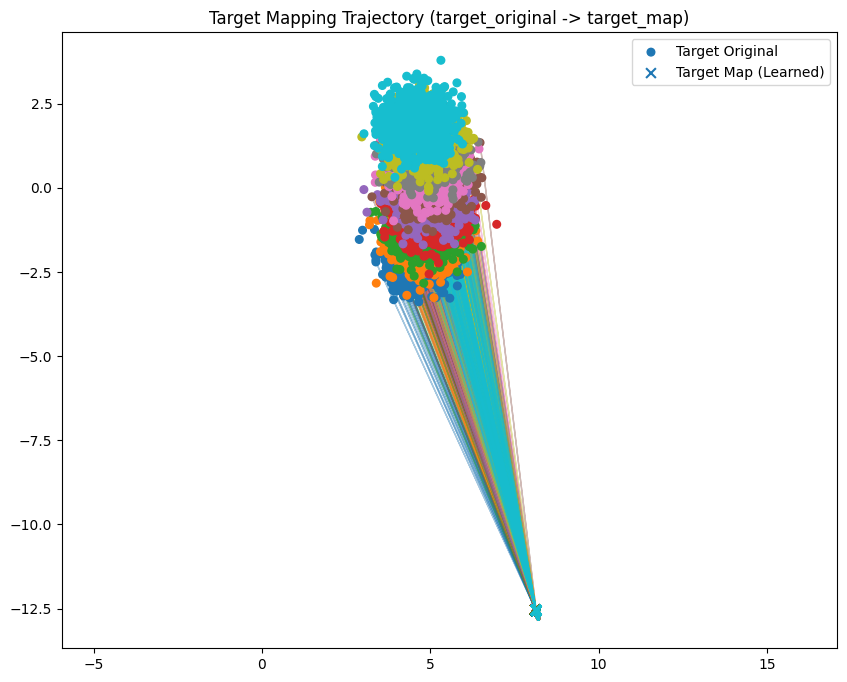

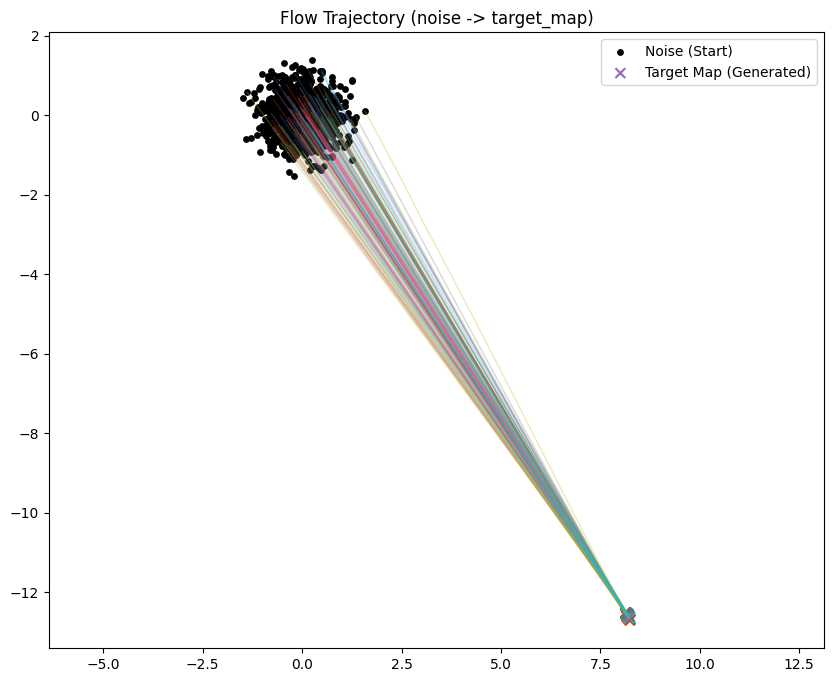

In [20]:
# --- 准备测试数据 ---
test_noise_samples = torch.from_numpy(noise_dist[:1000]).to(device)
test_orig_target = torch.from_numpy(target_original_dist).to(device)

# --- 生成映射和流的样本 ---
with torch.no_grad():
    # 1. 用 TargetNet 生成 target_map
    moved_targets = target_net(test_orig_target[:, :2])
    
    # 2. 用 FlowNet 从 noise 生成流向 target_map 的样本
    flow_trajectories = sample_fn(flow_net, 100, test_noise_samples)

original_targets_np = test_orig_target.cpu().numpy()
moved_targets_np = moved_targets.cpu().numpy()
target_map_generated = flow_trajectories[-1].numpy()
noise_np = test_noise_samples.cpu().numpy()

# --- 1. 绘制“映射”轨迹图 (target_original -> target_map) ---
plt.figure(figsize=(10, 8))
plt.title("Target Mapping Trajectory (target_original -> target_map)")
for i in range(num_classes):
    class_mask = (original_targets_np[:, 2] == i)
    if not np.any(class_mask): continue
    
    start_points = original_targets_np[class_mask, :2]
    end_points = moved_targets_np[class_mask, :2]
    
    for j in range(0, start_points.shape[0], 10):
        plt.arrow(start_points[j, 0], start_points[j, 1], 
                  end_points[j, 0] - start_points[j, 0], 
                  end_points[j, 1] - start_points[j, 1], 
                  color=colors(i), alpha=0.4, head_width=0.2)

plt.scatter(original_targets_np[:, 0], original_targets_np[:, 1], c=original_targets_np[:, 2], cmap=colors, marker="o", s=30, label="Target Original")
plt.scatter(moved_targets_np[:, 0], moved_targets_np[:, 1], c=original_targets_np[:, 2], cmap=colors, marker="x", s=50, edgecolor='black', label="Target Map (Learned)")
plt.legend()
plt.axis('equal')
plt.show()

# --- 2. 绘制 Flow 的轨迹图 (noise -> target_map) ---
plt.figure(figsize=(10, 8))
plt.title("Flow Trajectory (noise -> target_map)")
for i in range(num_classes):
    class_mask = noise_np[:, 2] == i
    if not np.any(class_mask): continue
    
    trajectories_class = flow_trajectories[:, class_mask, :]
    for j in range(0, trajectories_class.shape[1], 10):
        plt.plot(trajectories_class[:, j, 0], trajectories_class[:, j, 1], color=colors(i), alpha=0.3, linewidth=1.0)
        
plt.scatter(noise_np[:, 0], noise_np[:, 1], color='black', s=15, label="Noise (Start)")
plt.scatter(target_map_generated[:, 0], target_map_generated[:, 1], c=noise_np[:, 2], cmap=colors, marker="x", s=50, label="Target Map (Generated)")
plt.legend()
plt.axis('equal')
plt.show()

# 5

In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

# --- 初始化、数据生成、网络定义 (与之前完全相同) ---
# Seed, device setup...
set_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def sample_multimodal_distribution(modes, std, num_samples_per_mode=1000):
    # ... (代码与之前相同)
    dataset = []
    num_classes = modes.shape[0]
    for i in range(num_classes):
        for _ in range(num_samples_per_mode):
            sample = np.random.randn(modes.shape[1]) * std + modes[i]
            instance = np.concatenate((sample, np.array([i])))
            dataset.append(instance)
    return np.array(dataset, dtype="float32")

num_classes = 10
dataset_size = 10000
std = 0.5
modes_0 = np.array([[0, 0]])
noise_dist = sample_multimodal_distribution(modes_0, std, num_samples_per_mode=dataset_size)
noise_dist[:, 2] = np.random.randint(0, num_classes, dataset_size)
radius_orig = 5.0
theta_orig = np.linspace(-np.pi / 8, np.pi / 8, num_classes)
modes_orig = np.array([(radius_orig * np.cos(t), radius_orig * np.sin(t)) for t in theta_orig])
target_original_dist = sample_multimodal_distribution(modes_orig, std, num_samples_per_mode=dataset_size // num_classes)
colors = plt.cm.get_cmap('tab10', num_classes)

class TargetNet(nn.Module):
    def __init__(self, in_dim=2, h_dim=128, out_dim=2):
        super(TargetNet, self).__init__()
        self.network = nn.Sequential(nn.Linear(in_dim, h_dim), nn.ReLU(), nn.Linear(h_dim, h_dim), nn.ReLU(), nn.Linear(h_dim, out_dim))
    def forward(self, x): return self.network(x)

class FlowNet(nn.Module):
    def __init__(self, num_classes, in_dim=2, context_dim=1, h_dim=256, out_dim=2):
        super(FlowNet, self).__init__()
        self.embedding_table = nn.Embedding(num_classes, in_dim + context_dim)
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h_dim), nn.Tanh(), nn.Linear(h_dim, h_dim), nn.Tanh())
        self.flow_head = nn.Linear(h_dim, out_dim)
        self.classifier_head = nn.Linear(h_dim, num_classes)
    def forward(self, x, context, target_class):
        class_embedding = self.embedding_table(target_class)
        x_t = torch.cat((x, context), dim=1)
        x_t_by_c = x_t + class_embedding
        hidden = self.network(x_t_by_c)
        flow_pred, class_pred = self.flow_head(hidden), self.classifier_head(hidden)
        return flow_pred, class_pred
# --- 定义结束 ---


# 新的、最终的训练函数
def train_final_system(
    target_net, flow_net, optimizer,
    train_dataloader, NB_EPOCHS,
    target_radius=15.0,
    class_lambda=1.0,
    ring_lambda=2.0,          # 圆环损失权重
    separation_lambda=2.0     # 目标分散损失权重 (这是关键)
):
    criterion_class = nn.CrossEntropyLoss()
    
    for epoch in tqdm(range(NB_EPOCHS), desc="Training Final System"):
        for z0_batch, z1_orig_batch in train_dataloader:
            z0_batch, z1_orig_batch = z0_batch.to(device), z1_orig_batch.to(device)
            
            z0 = z0_batch[:, :2]
            z1_orig = z1_orig_batch[:, :2]
            target_class = z1_orig_batch[:, 2].long()
            
            # 1. TargetNet 生成 target_map (z1_map)
            z1_map = target_net(z1_orig)
            
            # 2. FlowNet 学习 flow
            t = torch.rand((z0_batch.shape[0], 1), device=device)
            z_t = t * z1_map + (1. - t) * z0
            target_flow = z1_map - z0
            flow_pred, class_pred = flow_net(z_t, t, target_class)
            
            # --- 计算四重损失 ---
            # a. 流匹配损失 (我们仍然可以使用对比版本来增强轨迹分离)
            loss_flow_base = (target_flow - flow_pred).pow(2).sum(dim=1).mean()
            negative_idx = torch.randperm(flow_pred.shape[0])
            negatives = target_flow[negative_idx]
            loss_contrastive = (negatives - flow_pred).pow(2).sum(dim=1).mean()
            loss_flow = loss_flow_base - 0.1 * loss_contrastive # 使用一个小的lambda

            # b. 圆环损失 (施加在 TargetNet 输出上)
            z1_map_norm = torch.linalg.norm(z1_map, dim=1)
            loss_ring = ((z1_map_norm - target_radius)**2).mean()
            
            # c. 目标分散损失 (Target Separation Loss)
            dists = torch.cdist(z1_map, z1_map, p=2)
            mask = target_class.view(-1, 1) != target_class.view(1, -1)
            # 惩罚小距离，我们最小化 exp(-dist^2)，即最大化距离
            loss_separation = torch.exp(-dists[mask].pow(2)).mean()
            
            # d. 分类损失
            loss_class = criterion_class(class_pred, target_class)
            
            # 总损失
            loss = loss_flow + class_lambda * loss_class + ring_lambda * loss_ring + separation_lambda * loss_separation
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- 实例化并训练 ---
target_net = TargetNet().to(device)
flow_net = FlowNet(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(list(target_net.parameters()) + list(flow_net.parameters()), lr=1e-3)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2):
        self.dist1, self.dist2 = dist1, dist2
    def __len__(self): return self.dist1.shape[0]
    def __getitem__(self, idx): return self.dist1[idx], self.dist2[idx % self.dist2.shape[0]]

dataset = Dataset(noise_dist, target_original_dist)
train_dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)

train_final_system(
    target_net, flow_net, optimizer, train_dataloader,
    NB_EPOCHS=1000,
    target_radius=15.0,
    ring_lambda=2.0,
    separation_lambda=2.0 # 加大分散损失的权重
)

/tmp/ipykernel_4001044/619407043.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)
Training Final System: 100%|██████████| 1000/1000 [01:33<00:00, 10.68it/s]


/tmp/ipykernel_4001044/958868278.py:39: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(moved_targets_np[:, 0], moved_targets_np[:, 1], c=original_targets_np[:, 2], cmap=colors, marker="x", s=50, edgecolor='black', label="Target Map (Learned)")


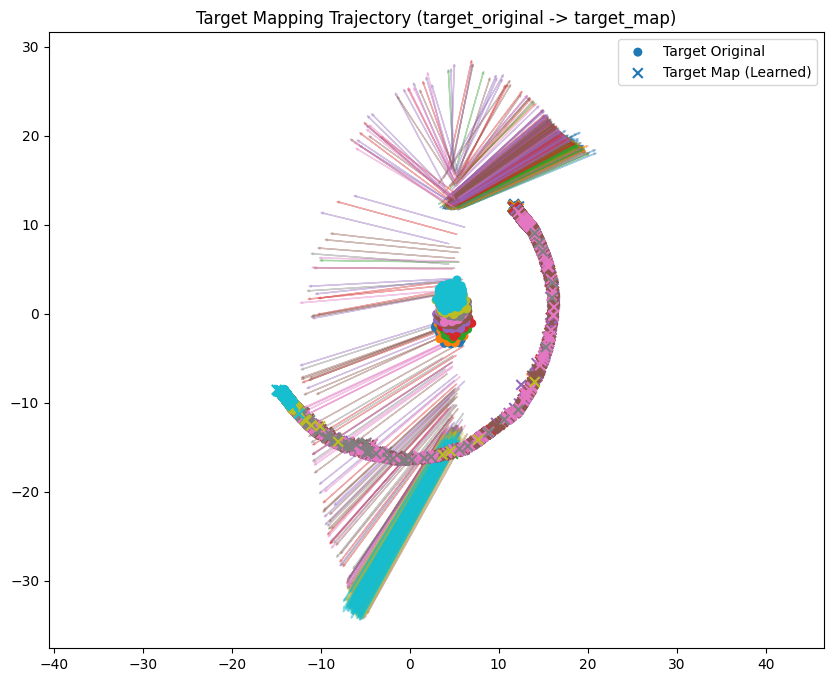

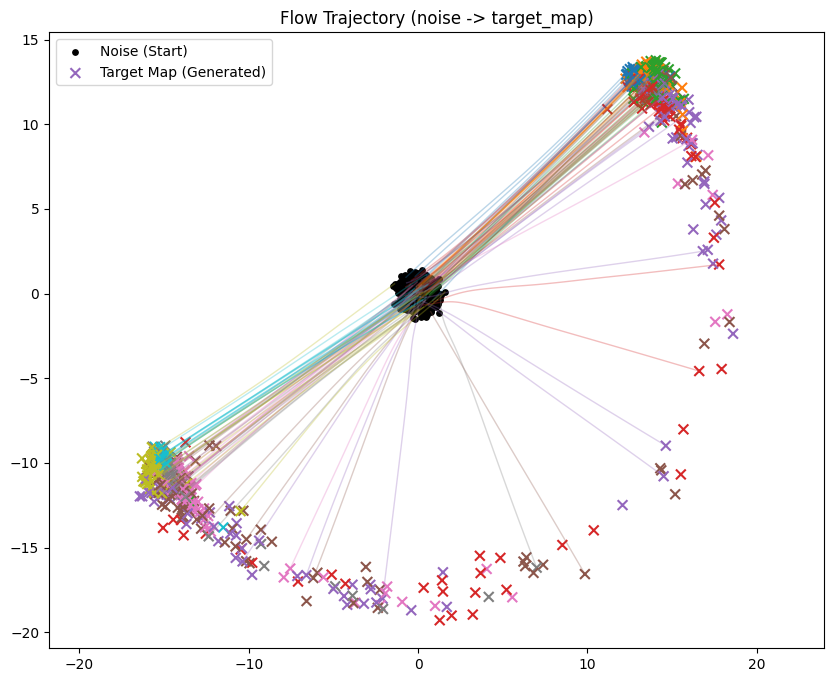

In [22]:
# --- 采样和可视化的代码与上次完全相同 ---
def sample_fn(flow_net, T, pi_0_samples):
    samples = [pi_0_samples[:,:2].clone().unsqueeze(0)]
    target_class = pi_0_samples[:,2].long()
    for i in range(T):
        t = torch.ones((pi_0_samples.shape[0], 1), device=device) * i / T
        inp_coords = samples[-1].squeeze(0)
        flow_pred, _ = flow_net(inp_coords, t, target_class)
        next_sample = samples[-1].squeeze(0) + flow_pred / T
        samples.append(next_sample.unsqueeze(0))
    return torch.cat(samples).cpu().detach()

test_noise_samples = torch.from_numpy(noise_dist[:1000]).to(device)
test_orig_target = torch.from_numpy(target_original_dist).to(device)

with torch.no_grad():
    moved_targets = target_net(test_orig_target[:, :2])
    flow_trajectories = sample_fn(flow_net, 100, test_noise_samples)

original_targets_np = test_orig_target.cpu().numpy()
moved_targets_np = moved_targets.cpu().numpy()
target_map_generated = flow_trajectories[-1].numpy()
noise_np = test_noise_samples.cpu().numpy()

# --- 1. 绘制“映射”轨迹图 (target_original -> target_map) ---
plt.figure(figsize=(10, 8))
plt.title("Target Mapping Trajectory (target_original -> target_map)")
for i in range(num_classes):
    class_mask = (original_targets_np[:, 2] == i)
    if not np.any(class_mask): continue
    start_points = original_targets_np[class_mask, :2]
    end_points = moved_targets_np[class_mask, :2]
    for j in range(0, start_points.shape[0], 10):
        plt.arrow(start_points[j, 0], end_points[j, 0], 
                  end_points[j, 1] - start_points[j, 1], 
                  end_points[j, 0] - start_points[j, 0], 
                  color=colors(i), alpha=0.4, head_width=0.2)
plt.scatter(original_targets_np[:, 0], original_targets_np[:, 1], c=original_targets_np[:, 2], cmap=colors, marker="o", s=30, label="Target Original")
plt.scatter(moved_targets_np[:, 0], moved_targets_np[:, 1], c=original_targets_np[:, 2], cmap=colors, marker="x", s=50, edgecolor='black', label="Target Map (Learned)")
plt.legend()
plt.axis('equal')
plt.show()

# --- 2. 绘制 Flow 的轨迹图 (noise -> target_map) ---
plt.figure(figsize=(10, 8))
plt.title("Flow Trajectory (noise -> target_map)")
for i in range(num_classes):
    class_mask = noise_np[:, 2] == i
    if not np.any(class_mask): continue
    trajectories_class = flow_trajectories[:, class_mask, :]
    for j in range(0, trajectories_class.shape[1], 10):
        plt.plot(trajectories_class[:, j, 0], trajectories_class[:, j, 1], color=colors(i), alpha=0.3, linewidth=1.0)
plt.scatter(noise_np[:, 0], noise_np[:, 1], color='black', s=15, label="Noise (Start)")
plt.scatter(target_map_generated[:, 0], target_map_generated[:, 1], c=noise_np[:, 2], cmap=colors, marker="x", s=50, label="Target Map (Generated)")
plt.legend()
plt.axis('equal')
plt.show()

# 6 + metric

In [23]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

# --- 初始化与数据生成 (与之前相同) ---
def set_seed(seed):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(0)

def sample_multimodal_distribution(modes, std, num_samples_per_mode=1000):
    dataset = []; num_classes = modes.shape[0]
    for i in range(num_classes):
        for _ in range(num_samples_per_mode):
            sample = np.random.randn(modes.shape[1]) * std + modes[i]
            instance = np.concatenate((sample, np.array([i]))); dataset.append(instance)
    return np.array(dataset, dtype="float32")

num_classes = 10; dataset_size = 10000; std = 0.5
modes_0 = np.array([[0, 0]]); noise_dist = sample_multimodal_distribution(modes_0, std, num_samples_per_mode=dataset_size)
noise_dist[:, 2] = np.random.randint(0, num_classes, dataset_size)
radius_orig = 5.0; theta_orig = np.linspace(-np.pi / 8, np.pi / 8, num_classes)
modes_orig = np.array([(radius_orig * np.cos(t), radius_orig * np.sin(t)) for t in theta_orig])
target_original_dist = sample_multimodal_distribution(modes_orig, std, num_samples_per_mode=dataset_size // num_classes)
colors = plt.cm.get_cmap('tab10', num_classes)
# --- 数据准备结束 ---

# --- FlowNet 定义 (与之前相同) ---
class FlowNet(nn.Module):
    def __init__(self, num_classes, in_dim=2, context_dim=1, h_dim=256, out_dim=2):
        super(FlowNet, self).__init__(); self.embedding_table = nn.Embedding(num_classes, in_dim + context_dim); self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h_dim), nn.Tanh(), nn.Linear(h_dim, h_dim), nn.Tanh()); self.flow_head = nn.Linear(h_dim, out_dim); self.classifier_head = nn.Linear(h_dim, num_classes)
    def forward(self, x, context, target_class):
        class_embedding = self.embedding_table(target_class); x_t = torch.cat((x, context), dim=1); x_t_by_c = x_t + class_embedding; hidden = self.network(x_t_by_c); flow_pred = self.flow_head(hidden); class_pred = self.classifier_head(hidden); return flow_pred, class_pred

/tmp/ipykernel_4001044/912329099.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


In [25]:
def train_with_triplet_loss(
    flow_net, optimizer,
    train_dataloader, NB_EPOCHS,
    class_lambda=1.0,
    triplet_lambda=0.5, # (新增) 三重损失的权重
    margin=1.0          # (新增) Triplet Loss 的边界
):
    criterion_class = nn.CrossEntropyLoss()
    # (新增) 定义三重损失函数
    criterion_triplet = nn.TripletMarginLoss(margin=margin, p=2)
    
    for epoch in tqdm(range(NB_EPOCHS), desc="Training with Triplet Loss"):
        for z0_batch, z1_orig_batch in train_dataloader:
            z0_batch, z1_orig_batch = z0_batch.to(device), z1_orig_batch.to(device)
            z0, z1_orig, target_class = z0_batch[:, :2], z1_orig_batch[:, :2], z1_orig_batch[:, 2].long()
            
            target_flow = z1_orig - z0
            t = torch.rand((z0_batch.shape[0], 1), device=device)
            z_t = t * z1_orig + (1. - t) * z0
            
            flow_pred, class_pred = flow_net(z_t, t, target_class)
            
            # --- 计算三重损失 ---
            # a. 标准流匹配损失
            loss_flow = (target_flow - flow_pred).pow(2).sum(dim=1).mean()
            
            # b. 分类损失
            loss_class = criterion_class(class_pred, target_class)
            
            # c. (新增) 三重损失，直接作用于预测的流向量 flow_pred
            # 为了构建三元组，我们需要在批处理中找到正样本和负样本
            loss_triplet = 0.0
            for i in range(flow_pred.shape[0]):
                anchor = flow_pred[i].unsqueeze(0)
                anchor_label = target_class[i]
                
                # 找到一个正样本 (同类但非自身)
                positive_mask = (target_class == anchor_label) & (torch.arange(len(target_class)).to(device) != i)
                # 找到所有负样本 (不同类)
                negative_mask = target_class != anchor_label
                
                if torch.sum(positive_mask) > 0 and torch.sum(negative_mask) > 0:
                    positive_idx = torch.where(positive_mask)[0][0]
                    negative_idx = torch.where(negative_mask)[0][0]
                    
                    positive = flow_pred[positive_idx].unsqueeze(0)
                    negative = flow_pred[negative_idx].unsqueeze(0)
                    
                    loss_triplet += criterion_triplet(anchor, positive, negative)

            loss_triplet = loss_triplet / flow_pred.shape[0] if flow_pred.shape[0] > 0 else 0.0

            # 总损失
            loss = loss_flow + class_lambda * loss_class + triplet_lambda * loss_triplet
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- 实例化并训练 ---
flow_net = FlowNet(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(flow_net.parameters(), lr=1e-3)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2): self.dist1, self.dist2 = dist1, dist2
    def __len__(self): return self.dist1.shape[0]
    def __getitem__(self, idx): return self.dist1[idx], self.dist2[idx % self.dist2.shape[0]]

dataset = Dataset(noise_dist, target_original_dist)
train_dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

train_with_triplet_loss(
    flow_net, optimizer, train_dataloader,
    NB_EPOCHS=1000,
    triplet_lambda=0.5 # 给予三重损失足够的权重来拉开距离
)

Training with Triplet Loss: 100%|██████████| 1000/1000 [1:35:03<00:00,  5.70s/it]


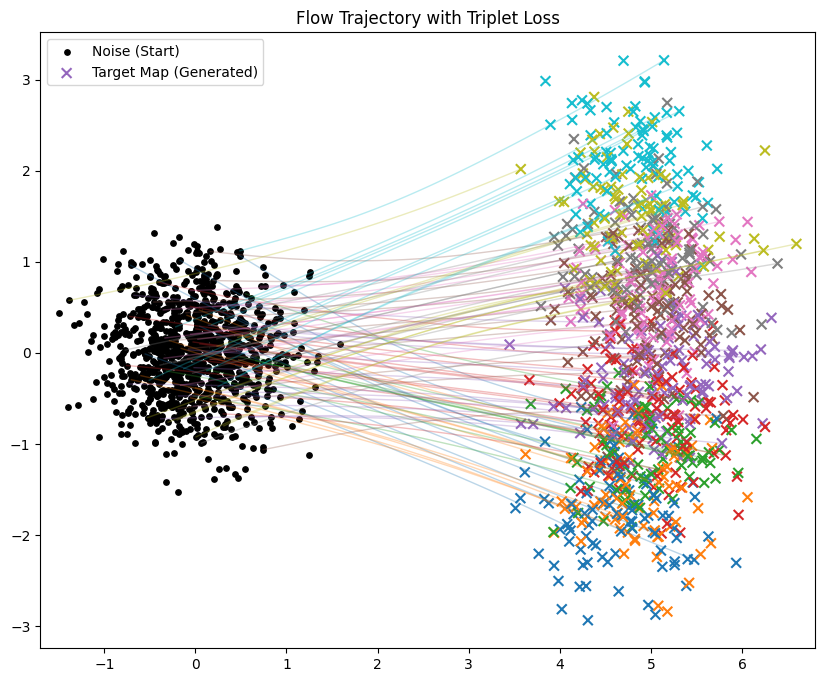

In [33]:
from sklearn.manifold import TSNE

# --- 采样函数 (与之前相同) ---
def sample_fn(flow_net, T, pi_0_samples):
    samples = [pi_0_samples[:,:2].clone().unsqueeze(0)]
    target_class = pi_0_samples[:,2].long()
    for i in range(T):
        t = torch.ones((pi_0_samples.shape[0], 1), device=device) * i / T
        inp_coords = samples[-1].squeeze(0)
        flow_pred, _ = flow_net(inp_coords, t, target_class)
        next_sample = samples[-1].squeeze(0) + flow_pred / T
        samples.append(next_sample.unsqueeze(0))
    return torch.cat(samples).cpu().detach()

# --- 生成样本 ---
test_noise_samples = torch.from_numpy(noise_dist[:1000]).to(device)
flow_trajectories = sample_fn(flow_net, 100, test_noise_samples)
target_map_generated = flow_trajectories[-1].numpy()
noise_np = test_noise_samples.cpu().numpy()

# --- 1. 绘制 Flow 的轨迹图 ---
plt.figure(figsize=(10, 8))
plt.title("Flow Trajectory with Triplet Loss")
for i in range(num_classes):
    class_mask = noise_np[:, 2] == i
    if not np.any(class_mask): continue
    trajectories_class = flow_trajectories[:, class_mask, :]
    for j in range(0, trajectories_class.shape[1], 10):
        plt.plot(trajectories_class[:, j, 0], trajectories_class[:, j, 1], color=colors(i), alpha=0.3, linewidth=1.0)
plt.scatter(noise_np[:, 0], noise_np[:, 1], color='black', s=15, label="Noise (Start)")
plt.scatter(target_map_generated[:, 0], target_map_generated[:, 1], c=noise_np[:, 2], cmap=colors, marker="x", s=50, label="Target Map (Generated)")
plt.legend(); plt.axis('equal'); plt.show()




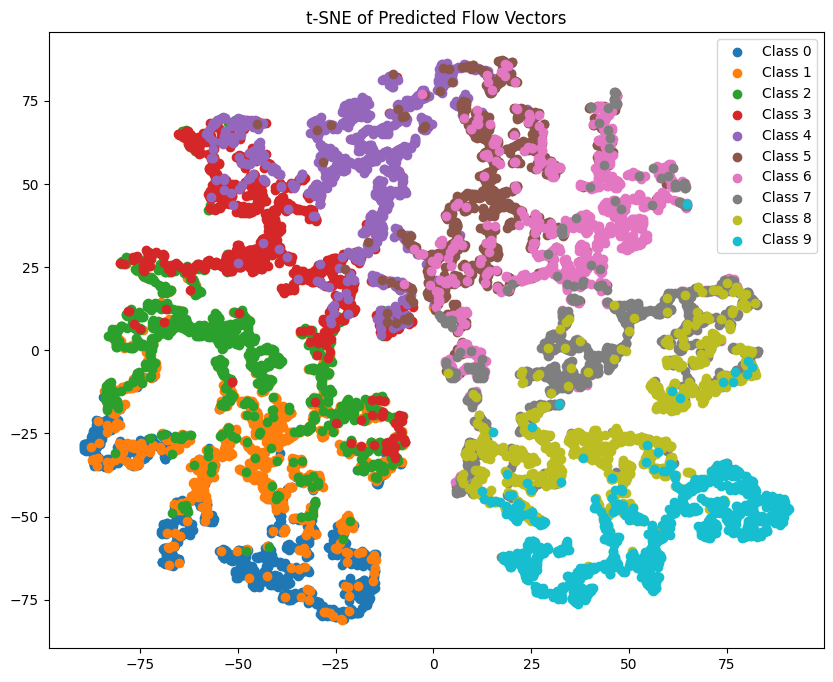

In [32]:
# --- 2. 绘制流向量的t-SNE降维图 ---
# 我们需要为一批测试数据生成预测的流向量
test_z0_batch = torch.from_numpy(noise_dist).to(device)
test_z1_orig_batch = torch.from_numpy(target_original_dist).to(device)
test_t = torch.rand(test_z1_orig_batch.shape[0], 1).to(device) # 在随机时间点t进行预测
test_z_t = test_t * test_z1_orig_batch[:, :2] + (1 - test_t) * test_z0_batch[:, :2]
test_target_class = test_z1_orig_batch[:, 2].long()

with torch.no_grad():
    flow_vectors_pred, _ = flow_net(test_z_t, test_t, test_target_class)

flow_vectors_pred_np = flow_vectors_pred.cpu().numpy()
labels_np = test_target_class.cpu().numpy()

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
flow_vectors_2d = tsne.fit_transform(flow_vectors_pred_np)

plt.figure(figsize=(10, 8))
plt.title("t-SNE of Predicted Flow Vectors")
for i in range(num_classes):
    plt.scatter(flow_vectors_2d[labels_np == i, 0], flow_vectors_2d[labels_np == i, 1], color=colors(i), label=f"Class {i}")
plt.legend()
plt.show()

# 7 LATENT SPACE

## DATA

In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import random

# --- 1. 初始化与数据生成 ---

def set_seed(seed):
    """为可复现性设置随机种子"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)
print(f"使用设备: {device}")

def create_demo_data(num_samples=2000, seq_len=2):
    """生成2D合成时间序列数据"""
    data, domains, systems, labels = [], [], [], []
    time = np.linspace(0, 1, seq_len)
    
    for i in range(num_samples):
        domain = np.random.randint(0, 2)
        system = np.random.randint(0, 2)
        label = np.random.randint(0, 2)
        
        # 根据 d, s, l 创建特征变化
        freq = 1.0 + system * 1
        amp = 0.5 + label * 0.4
        
        if domain == 0:
            series = amp * np.sin(freq * time + system * np.pi/2)
        else:
            series = amp * np.cos(freq * time + label * np.pi/4)
        
        # 添加少量噪声
        series += np.random.normal(0, 0.05, size=series.shape)
        
        data.append(series)
        domains.append(domain)
        systems.append(system)
        labels.append(label)
        
    return (torch.tensor(np.array(data), dtype=torch.float32),
            torch.tensor(domains, dtype=torch.long),
            torch.tensor(systems, dtype=torch.long),
            torch.tensor(labels, dtype=torch.long))



使用设备: cuda


In [28]:
# 生成数据
data, domains, systems, labels = create_demo_data(seq_len=2)
dataset = TensorDataset(data, domains, systems, labels)
dataloader = DataLoader(dataset, batch_size=2000, shuffle=True)

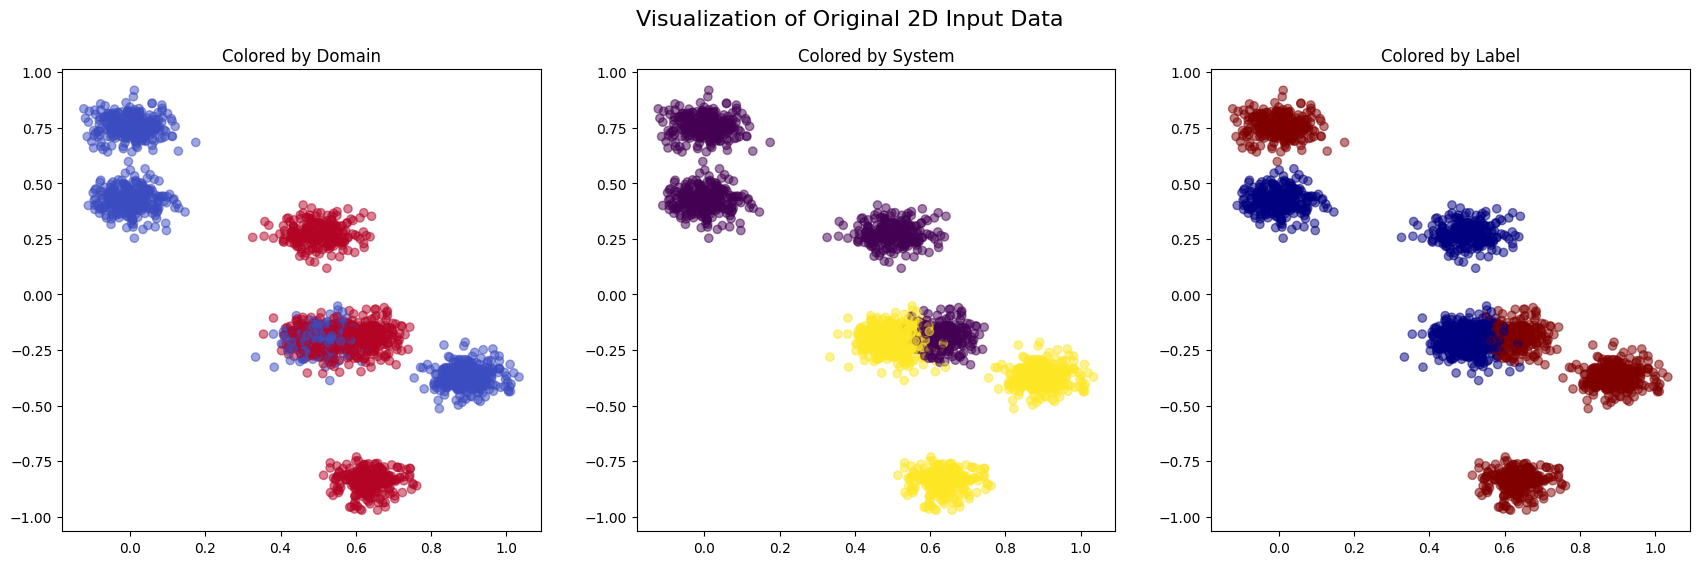

In [29]:
# a) 可视化原始数据
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle("Visualization of Original 2D Input Data", fontsize=16)
data_np, domains_np, systems_np, labels_np = data.numpy(), domains.numpy(), systems.numpy(), labels.numpy()
# (代码与上一步相同...)
axes[0].scatter(data_np[:, 0], data_np[:, 1], c=domains_np, cmap='coolwarm', alpha=0.5); axes[0].set_title('Colored by Domain')
axes[1].scatter(data_np[:, 0], data_np[:, 1], c=systems_np, cmap='viridis', alpha=0.5); axes[1].set_title('Colored by System')
axes[2].scatter(data_np[:, 0], data_np[:, 1], c=labels_np, cmap='jet', alpha=0.5); axes[2].set_title('Colored by Label')
plt.show()

/tmp/ipykernel_4013915/3259297848.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(data_np[mask, 0], data_np[mask, 1],


Text(0.5, 0, 'Feature 1')

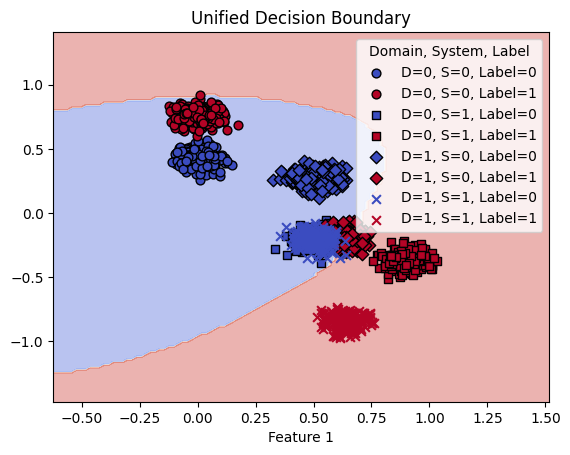

In [55]:
# 绘制决策边界
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)

# 绘制所有数据点，并为每个组合创建清晰的图例
markers = ['o', 's', 'D', 'x']  # 形状对应 (D,S) 组合
colors = {0: '#3b4cc0', 1: '#b40426'} # 颜色对应 Label (从 coolwarm 中提取)
combo_labels = domains_np * 2 + systems_np

# 遍历每一种 (domain, system) 和 label 的组合
for i in range(4):      # 遍历4种 (D,S) 组合
    for j in range(2):  # 遍历2种 Label
        # 创建一个掩码，只选择当前组合的数据点
        mask = (combo_labels == i) & (labels_np == j)
        
        # 如果存在这样的数据点，则绘制它们
        if np.any(mask):
            plt.scatter(data_np[mask, 0], data_np[mask, 1], 
                       c=colors[j],
                       edgecolors='k', 
                       s=40, 
                       marker=markers[i],
                       label=f'D={i//2}, S={i%2}, Label={j}')
plt.legend(title='Domain, System, Label', loc='upper right')
plt.title('Unified Decision Boundary')
plt.xlabel('Feature 1')

## Model

In [30]:
# --- 2. 模型架构定义 ---

class ConditionalEncoder(nn.Module):
    """条件编码器 E_phi"""
    def __init__(self, input_dim=2, latent_dim=2, num_domains=2, num_systems=2, cond_embed_dim=8):
        super().__init__()
        self.domain_embed = nn.Embedding(num_domains, cond_embed_dim)
        self.system_embed = nn.Embedding(num_systems, cond_embed_dim)
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64 + 2 * cond_embed_dim, 32)
        self.fc3 = nn.Linear(32, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x, domain, system):
        d_embed = self.domain_embed(domain)
        s_embed = self.system_embed(system)
        x = self.relu(self.fc1(x))
        x_cond = torch.cat([x, d_embed, s_embed], dim=1)
        x_cond = self.relu(self.fc2(x_cond))
        h = self.fc3(x_cond)
        return h

class Decoder(nn.Module):
    """解码器 D_psi"""
    def __init__(self, latent_dim=2, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, h):
        h = self.relu(self.fc1(h))
        h = self.relu(self.fc2(h))
        x_recon = self.fc3(h) # No activation for regression
        return x_recon

class FlowNet(nn.Module):
    """流模型 f_theta"""
    def __init__(self, latent_dim=2, condition_dim=2, hidden_dim=128):
        super().__init__()
        # 输入: z_t (latent_dim), t (1), h (condition_dim)
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 1 + condition_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim) # 输出: v_pred
        )

    def forward(self, z, t, h):
        zt_h = torch.cat([z, t, h], dim=1)
        v_pred = self.net(zt_h)
        return v_pred

class Classifier(nn.Module):
    """分类器 C_omega"""
    def __init__(self, latent_dim=2, num_labels=2, hidden_dim=64):
        super().__init__()
        # 输入: h 和 v_pred
        self.fc1 = nn.Linear(latent_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_labels)
        self.relu = nn.ReLU()

    def forward(self, h, v_pred):
        inp = torch.cat([h, v_pred], dim=1)
        out = self.relu(self.fc1(inp))
        logits = self.fc2(out)
        return logits

class VAEFlowModel(nn.Module):
    """将所有模块包装在一起的统一模型"""
    def __init__(self, input_dim=2, latent_dim=2, num_domains=2, num_systems=2, num_labels=2):
        super().__init__()
        self.encoder = ConditionalEncoder(input_dim, latent_dim, num_domains, num_systems)
        self.decoder = Decoder(latent_dim, input_dim)
        self.flow_net = FlowNet(latent_dim, latent_dim)
        self.classifier = Classifier(latent_dim, num_labels)

    def forward(self, x, domain, system, z0=None, t=None):
        # VAE 路径
        h = self.encoder(x, domain, system)
        x_recon = self.decoder(h)
        
        # Flow 路径
        if t is None: t = torch.rand(x.shape[0], 1).to(x.device)
        if z0 is None: z0 = torch.randn_like(h)
        
        z_t = t * h + (1 - t) * z0
        v_pred = self.flow_net(z_t, t, h)
        
        # 分类器路径
        y_pred_logits = self.classifier(h, v_pred)
        
        return x_recon, h, v_pred, y_pred_logits


## Loop

In [ ]:
# --- 3. 训练循环 ---
def train_model(model, dataloader, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_recon_fn = nn.MSELoss()
    loss_flow_fn = nn.MSELoss()
    loss_contrastive_fn = nn.TripletMarginLoss(margin=1.0)
    loss_class_fn = nn.CrossEntropyLoss()
    
    # 损失权重
    lambda_recon = 1.0
    lambda_flow = 1.0
    lambda_contrastive = 0.5
    lambda_class = 0.5
    
    model.train()
    for epoch in tqdm(range(epochs), desc="Training VAE-Flow Model"):
        for x_batch, d_batch, s_batch, y_batch in dataloader:
            x_batch, d_batch, s_batch, y_batch = (d.to(device) for d in [x_batch, d_batch, s_batch, y_batch])
            
            z0_batch = torch.randn(x_batch.size(0), 2).to(device) # latent_dim = 2
            x_recon, h, v_pred, y_pred_logits = model(x_batch, d_batch, s_batch, z0=z0_batch)
            
            # 1. 重构损失
            loss_r = loss_recon_fn(x_recon, x_batch)
            
            # 2. 流匹配损失
            v_true = h - z0_batch
            loss_f = loss_flow_fn(v_pred, v_true)
            
            # 3. 流对比损失 (Triplet Mining)
            loss_c = 0.0
            cond_pair = d_batch * 2 + s_batch # 将domain和system合并为唯一的组ID
            for i in range(x_batch.size(0)):
                anchor_v = v_pred[i].unsqueeze(0)
                anchor_cond = cond_pair[i]
                
                positive_mask = (cond_pair == anchor_cond) & (torch.arange(len(cond_pair)).to(device) != i)
                negative_mask = (cond_pair != anchor_cond)

                if positive_mask.sum() > 0 and negative_mask.sum() > 0:
                    pos_idx = torch.where(positive_mask)[0][torch.randint(0, positive_mask.sum(), (1,))]
                    neg_idx = torch.where(negative_mask)[0][torch.randint(0, negative_mask.sum(), (1,))]
                    loss_c += loss_contrastive_fn(anchor_v, v_pred[pos_idx], v_pred[neg_idx])
            loss_c = loss_c / x_batch.size(0) if x_batch.size(0) > 0 else torch.tensor(0.0).to(device)

            # 4. 分类损失
            loss_cl = loss_class_fn(y_pred_logits, y_batch)
            
            # 总损失
            total_loss = (lambda_recon * loss_r + 
                          lambda_flow * loss_f + 
                          lambda_contrastive * loss_c + 
                          lambda_class * loss_cl)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss.item():.4f}")
            print(f"  Recon: {loss_r.item():.4f}, Flow: {loss_f.item():.4f}, Contrastive: {loss_c.item():.4f}, Class: {loss_cl.item():.4f}")
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()


## run

In [32]:
model = VAEFlowModel(input_dim=2, latent_dim=2).to(device)
train_model(model, dataloader, epochs=200)

Training VAE-Flow Model:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Loss: 2.1577
  Recon: 0.2719, Flow: 1.0381, Contrastive: 1.0004, Class: 0.6951
Epoch 2/200, Loss: 2.1092
  Recon: 0.2617, Flow: 1.0006, Contrastive: 0.9993, Class: 0.6944
Epoch 3/200, Loss: 2.0459
  Recon: 0.2526, Flow: 0.9465, Contrastive: 0.9996, Class: 0.6938
Epoch 4/200, Loss: 1.9994
  Recon: 0.2447, Flow: 0.9092, Contrastive: 0.9978, Class: 0.6933
Epoch 5/200, Loss: 1.9410
  Recon: 0.2373, Flow: 0.8579, Contrastive: 0.9988, Class: 0.6929
Epoch 6/200, Loss: 1.9087
  Recon: 0.2305, Flow: 0.8308, Contrastive: 1.0021, Class: 0.6926
Epoch 7/200, Loss: 1.8561
  Recon: 0.2244, Flow: 0.7852, Contrastive: 1.0007, Class: 0.6924
Epoch 8/200, Loss: 1.8524
  Recon: 0.2189, Flow: 0.7828, Contrastive: 1.0091, Class: 0.6923
Epoch 9/200, Loss: 1.7963
  Recon: 0.2139, Flow: 0.7380, Contrastive: 0.9961, Class: 0.6927
Epoch 10/200, Loss: 1.7580
  Recon: 0.2090, Flow: 0.7001, Contrastive: 1.0052, Class: 0.6926
Epoch 11/200, Loss: 1.7026
  Recon: 0.2041, Flow: 0.6509, Contrastive: 1.0028, 

## plot

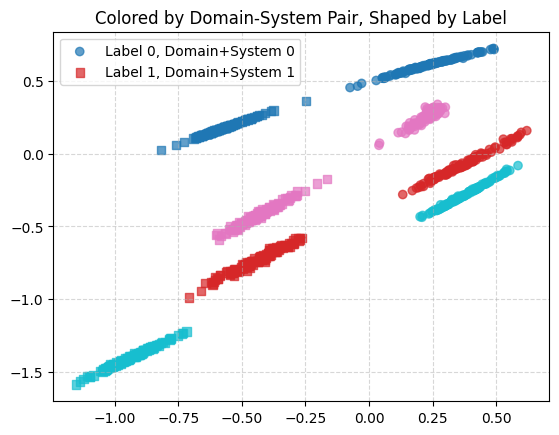

In [ ]:
# --- 5. 可视化 ---

# b) 可视化学习到的潜在空间 h
model.eval()
test_data, test_d, test_s, test_y = create_demo_data(num_samples=1000)
test_dataset = TensorDataset(test_data, test_d, test_s, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=128)
all_h, all_d, all_s, all_c = [], [], [], []
with torch.no_grad():
    for x, d, s, c in test_dataloader:
        x, d, s = x.to(device), d.to(device), s.to(device)
        h = model.encoder(x, d, s)
        all_h.append(h.cpu().numpy()); all_d.append(d.cpu().numpy()); all_s.append(s.cpu().numpy()); all_c.append(c.cpu().numpy())
all_h, all_d, all_s, all_c = np.concatenate(all_h), np.concatenate(all_d), np.concatenate(all_s), np.concatenate(all_c)

# 按 Domain+System 组合着色 (4个组合)
combo_labels = all_d * 2 + all_s
markers = ['o', 's', 'D', 'x']  # 不同的标记

# Create separate scatter plots for each label type
for label_val in np.unique(all_c):
    mask = all_c == label_val
    plt.scatter(all_h[mask, 0], all_h[mask, 1], c=combo_labels[mask], 
                    marker=markers[label_val], cmap='tab10', alpha=0.7, 
                    label=f'Label {label_val}, Domain+System {combo_labels[mask][0]}')

plt.title('Colored by Domain-System Pair, Shaped by Label')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)


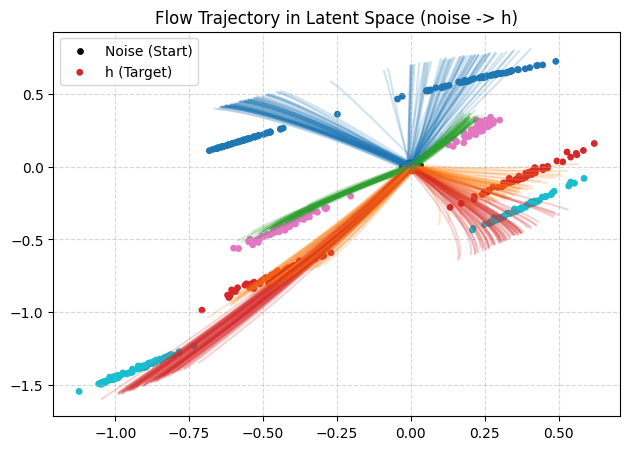

In [56]:
# c) 可视化Flow采样过程
test_samples_for_flow = 500
x_flow, d_flow, s_flow, _ = test_data[:test_samples_for_flow], test_d[:test_samples_for_flow], test_s[:test_samples_for_flow], test_y[:test_samples_for_flow]
x_flow, d_flow, s_flow = x_flow.to(device), d_flow.to(device), s_flow.to(device)

h_targets = model.encoder(x_flow, d_flow, s_flow).detach()
z0_flow = torch.randn_like(h_targets)*0.01 

# 采样轨迹
trajectories = [z0_flow.clone().unsqueeze(0)]
model.eval()
with torch.no_grad():
    for t_step in np.linspace(0, 1, 100):
        t = torch.full((test_samples_for_flow, 1), t_step).to(device)
        z_t = trajectories[-1].squeeze(0)
        v_pred = model.flow_net(z_t, t, h_targets)
        z_next = z_t + v_pred * (1.0/100.0) # dt = 1/100
        trajectories.append(z_next.unsqueeze(0))

trajectories_np = torch.cat(trajectories).cpu().numpy()
h_targets_np = h_targets.cpu().numpy()
combo_labels_flow = (d_flow * 2 + s_flow).cpu().numpy()

# 绘制流轨迹
plt.title('Flow Trajectory in Latent Space (noise -> h)')
for i in range(test_samples_for_flow):
    plt.plot(trajectories_np[:, i, 0], trajectories_np[:, i, 1], 
             color=plt.cm.tab10(combo_labels_flow[i]), alpha=0.2)

# 绘制起点和终点
plt.scatter(trajectories_np[0, :, 0], trajectories_np[0, :, 1], color='black', s=15, label='Noise (Start)')
scatter2 = plt.scatter(h_targets_np[:, 0], h_targets_np[:, 1], c=combo_labels_flow, cmap='tab10', s=15, label='h (Target)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# 8 pretraining loss EBLO flow flow 对比loss 正则化loss

## data

In [59]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import random

# --- 1. 初始化与数据生成 ---

def set_seed(seed):
    """为可复现性设置随机种子"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)
print(f"使用设备: {device}")

def create_demo_data(num_samples=2000, seq_len=2):
    """生成2D合成时间序列数据"""
    data, domains, systems, labels = [], [], [], []
    time = np.linspace(0, 1, seq_len)
    
    for i in range(num_samples):
        domain = np.random.randint(0, 2)
        system = np.random.randint(0, 2)
        label = np.random.randint(0, 2)
        
        # 根据 d, s, l 创建特征变化
        freq = 1.0 + system * 1
        amp = 0.5 + label * 0.4
        
        if domain == 0:
            series = amp * np.sin(freq * time + system * np.pi/2)
        else:
            series = amp * np.cos(freq * time + label * np.pi/4)
        
        # 添加少量噪声
        series += np.random.normal(0, 0.05, size=series.shape)
        
        data.append(series)
        domains.append(domain)
        systems.append(system)
        labels.append(label)
        
    return (torch.tensor(np.array(data), dtype=torch.float32),
            torch.tensor(domains, dtype=torch.long),
            torch.tensor(systems, dtype=torch.long),
            torch.tensor(labels, dtype=torch.long))



使用设备: cuda


In [61]:
# 生成数据
data, domains, systems, labels = create_demo_data(seq_len=2)
dataset = TensorDataset(data, domains, systems, labels)
dataloader = DataLoader(dataset, batch_size=2000, shuffle=True)

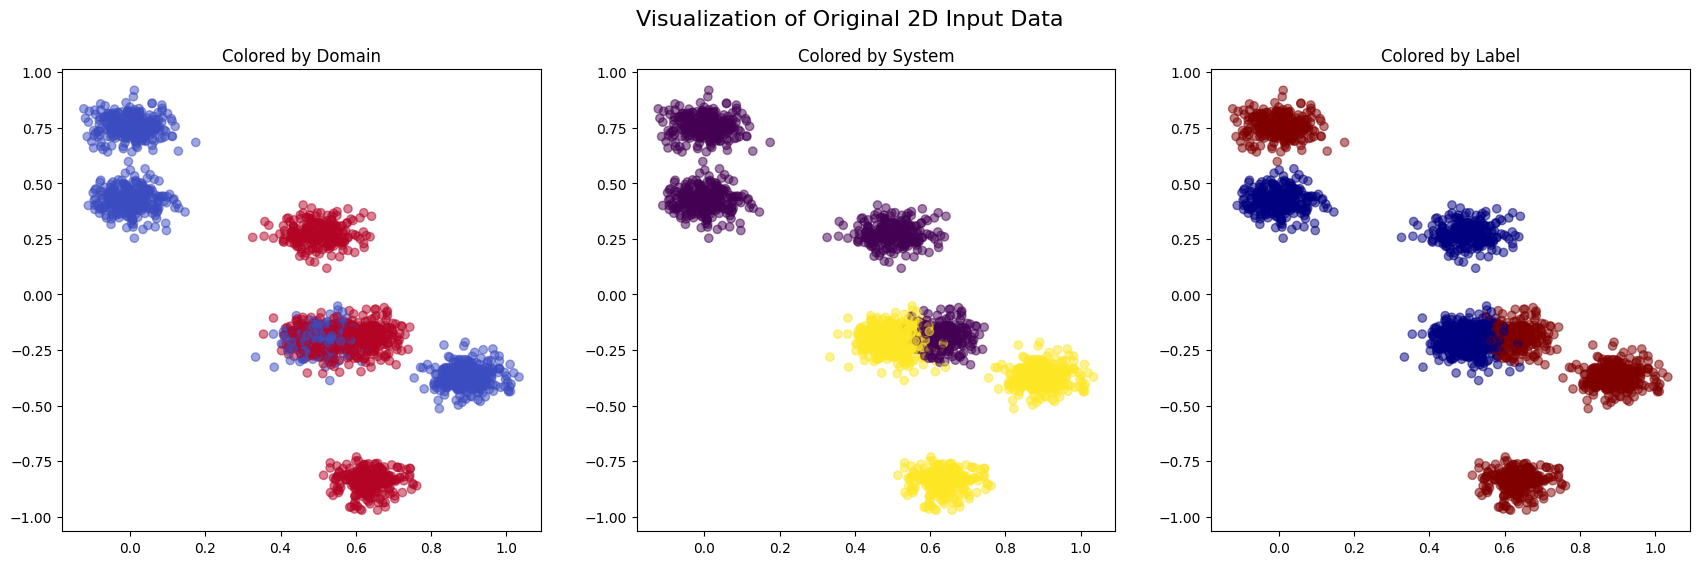

In [62]:
# a) 可视化原始数据
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle("Visualization of Original 2D Input Data", fontsize=16)
data_np, domains_np, systems_np, labels_np = data.numpy(), domains.numpy(), systems.numpy(), labels.numpy()
# (代码与上一步相同...)
axes[0].scatter(data_np[:, 0], data_np[:, 1], c=domains_np, cmap='coolwarm', alpha=0.5); axes[0].set_title('Colored by Domain')
axes[1].scatter(data_np[:, 0], data_np[:, 1], c=systems_np, cmap='viridis', alpha=0.5); axes[1].set_title('Colored by System')
axes[2].scatter(data_np[:, 0], data_np[:, 1], c=labels_np, cmap='jet', alpha=0.5); axes[2].set_title('Colored by Label')
plt.show()

## model

In [64]:
# --- 更新后的模型架构 ---

class ConditionalEncoder(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, num_domains=2, num_systems=2, cond_embed_dim=8):
        super().__init__()
        self.domain_embed = nn.Embedding(num_domains, cond_embed_dim)
        self.system_embed = nn.Embedding(num_systems, cond_embed_dim)
        self.net = nn.Sequential(
            nn.Linear(input_dim + 2 * cond_embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_log_var = nn.Linear(32, latent_dim)

    def forward(self, x, domain, system):
        d_embed = self.domain_embed(domain)
        s_embed = self.system_embed(system)
        x_cond = torch.cat([x, d_embed, s_embed], dim=1)
        hidden = self.net(x_cond)
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        return mu, log_var

class Decoder(nn.Module):
    # ... (与之前相同，无需修改)
    def __init__(self, latent_dim=2, output_dim=2):
        super().__init__(); self.net = nn.Sequential(nn.Linear(latent_dim, 32), nn.ReLU(), nn.Linear(32, 64), nn.ReLU(), nn.Linear(64, output_dim))
    def forward(self, h): return self.net(h)

class FlowNet(nn.Module):
    # ... (与之前相同，无需修改)
    def __init__(self, latent_dim=2, condition_dim=2, hidden_dim=128):
        super().__init__(); self.net = nn.Sequential(nn.Linear(latent_dim + 1 + condition_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, latent_dim))
    def forward(self, z, t, h): return self.net(torch.cat([z, t, h], dim=1))

class VAEFlowModel(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, num_domains=2, num_systems=2):
        super().__init__()
        self.encoder = ConditionalEncoder(input_dim, latent_dim, num_domains, num_systems)
        self.decoder = Decoder(latent_dim, input_dim)
        self.flow_net = FlowNet(latent_dim, latent_dim)
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, domain, system, z0=None, t=None):
        mu, log_var = self.encoder(x, domain, system)
        h = self.reparameterize(mu, log_var)
        x_recon = self.decoder(h)
        
        if t is None: t = torch.rand(x.shape[0], 1).to(x.device)
        if z0 is None: z0 = torch.randn_like(h)
        
        z_t = t * h + (1 - t) * z0
        v_pred = self.flow_net(z_t, t, h)
        
        return x_recon, h, v_pred, mu, log_var

## loop

Training Final Model:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000, Loss: 10.5226
  ELBO: 0.2381, Flow: 2.1154, Contrastive: 1.4986, Reg: 3.3353
Epoch 2/1000, Loss: 10.6375
  ELBO: 0.2290, Flow: 2.1384, Contrastive: 1.4981, Reg: 3.3859
Epoch 3/1000, Loss: 10.1877
  ELBO: 0.2251, Flow: 2.0866, Contrastive: 1.4997, Reg: 3.1882
Epoch 4/1000, Loss: 9.9851
  ELBO: 0.2183, Flow: 2.0679, Contrastive: 1.4970, Reg: 3.1009
Epoch 5/1000, Loss: 9.8989
  ELBO: 0.2134, Flow: 1.9244, Contrastive: 1.4998, Reg: 3.1307
Epoch 6/1000, Loss: 9.8427
  ELBO: 0.2066, Flow: 2.0154, Contrastive: 1.4983, Reg: 3.0612
Epoch 7/1000, Loss: 9.3320
  ELBO: 0.2060, Flow: 1.9388, Contrastive: 1.4915, Reg: 2.8478
Epoch 8/1000, Loss: 9.2096
  ELBO: 0.2036, Flow: 1.9732, Contrastive: 1.4938, Reg: 2.7695
Epoch 9/1000, Loss: 9.0293
  ELBO: 0.2035, Flow: 1.9367, Contrastive: 1.5037, Reg: 2.6927
Epoch 10/1000, Loss: 8.7121
  ELBO: 0.2018, Flow: 1.8629, Contrastive: 1.4811, Reg: 2.5831
Epoch 11/1000, Loss: 8.5919
  ELBO: 0.2076, Flow: 1.8688, Contrastive: 1.5026, Reg: 2.5064
Epoch

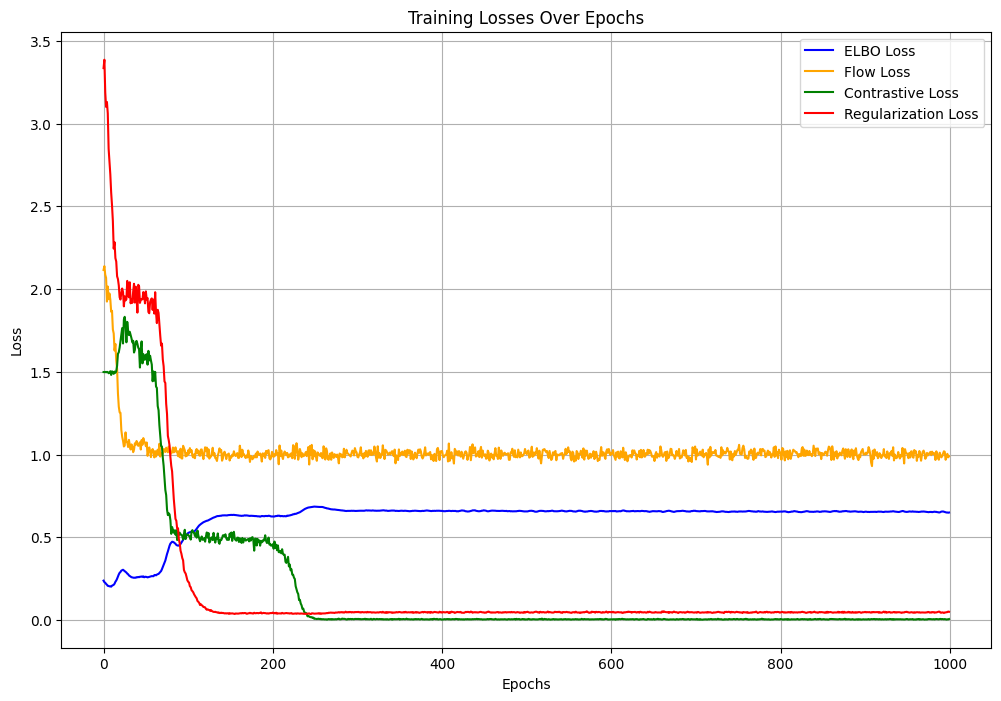

In [68]:
def train_final_model(model, dataloader, epochs=300, target_radius=3.0, margin=1.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_recon_fn = nn.MSELoss()
    loss_flow_fn = nn.MSELoss()
    loss_contrastive_fn = nn.TripletMarginLoss(margin=margin)
    
    # 损失权重
    lambda_kl = 0.1
    lambda_flow = 1.0
    lambda_contrastive = 1.0
    lambda_reg = 2.0

    model.train()
    loss_epoch = {
        "ELBO": [],
        "Flow": [],
        "Contrastive": [],
        "Reg": []
    }
    for epoch in tqdm(range(epochs), desc="Training Final Model"):
        for x_batch, d_batch, s_batch, c_batch in dataloader:
            x_batch, d_batch, s_batch = x_batch.to(device), d_batch.to(device), s_batch.to(device)
            
            x_recon, h, v_pred, mu, log_var = model(x_batch, d_batch, s_batch)
            
            # --- 1. ELBO 损失 ---
            loss_r = loss_recon_fn(x_recon, x_batch)
            loss_kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / x_batch.size(0)
            loss_elbo = loss_r + lambda_kl * loss_kl
            
            # --- 2. Flow 匹配损失 ---
            z0 = torch.randn_like(h)
            v_true = h - z0
            loss_f = loss_flow_fn(v_pred, v_true)
            
            # --- 3. Flow 对比损失 ---
            loss_c = 0.0
            cond_pair = d_batch * 2 + s_batch
            for i in range(x_batch.size(0)):
                # ... (Triplet Mining 代码与之前相同)
                anchor_v = v_pred[i].unsqueeze(0); anchor_cond = cond_pair[i]
                positive_mask = (cond_pair == anchor_cond) & (torch.arange(len(cond_pair)).to(device) != i)
                negative_mask = (cond_pair != anchor_cond)
                if positive_mask.sum() > 0 and negative_mask.sum() > 0:
                    pos_idx = torch.where(positive_mask)[0][torch.randint(0, positive_mask.sum(), (1,))]
                    neg_idx = torch.where(negative_mask)[0][torch.randint(0, negative_mask.sum(), (1,))]
                    loss_c += loss_contrastive_fn(anchor_v, v_pred[pos_idx], v_pred[neg_idx])
            loss_c = loss_c / x_batch.size(0) if x_batch.size(0) > 0 else torch.tensor(0.0).to(device)

            # --- 4. 特征正则化损失 ---
            loss_center = h.mean(dim=0).pow(2).sum()
            loss_radius = ((torch.linalg.norm(h, dim=1) - target_radius)**2).mean()
            loss_reg = loss_center + loss_radius

            # --- 总损失 ---
            total_loss = loss_elbo + lambda_flow * loss_f + lambda_contrastive * loss_c + lambda_reg * loss_reg
            
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss.item():.4f}")
            print(f"  ELBO: {loss_elbo.item():.4f}, Flow: {loss_f.item():.4f}, Contrastive: {loss_c.item():.4f}, Reg: {loss_reg.item():.4f}")
            loss_epoch["ELBO"].append(loss_elbo.item())
            loss_epoch["Flow"].append(loss_f.item())
            loss_epoch["Contrastive"].append(loss_c.item())
            loss_epoch["Reg"].append(loss_reg.item())
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
    return loss_epoch

# --- 执行训练 ---
model = VAEFlowModel(input_dim=2, latent_dim=2).to(device)
loss_epoch = train_final_model(model, dataloader, epochs=1000, target_radius=3.0, margin=1.5)
# --- 保存损失及可视化
plt.figure(figsize=(12, 8))
plt.plot(loss_epoch["ELBO"], label="ELBO Loss", color='blue')
plt.plot(loss_epoch["Flow"], label="Flow Loss", color='orange')
plt.plot(loss_epoch["Contrastive"], label="Contrastive Loss", color='green')
plt.plot(loss_epoch["Reg"], label="Regularization Loss", color='red')
plt.title("Training Losses Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
import pandas as pd
pd.DataFrame(loss_epoch).to_csv("loss_epoch.csv", index=False)




## plot

In [73]:
# --- 5. 可视化 ---

# b) 可视化学习到的潜在空间 h
model.eval()
test_data, test_d, test_s, test_y = create_demo_data(num_samples=1000)
test_dataset = TensorDataset(test_data, test_d, test_s, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=128)
all_h, all_d, all_s, all_c = [], [], [], []
with torch.no_grad():
    for x, d, s, c in test_dataloader:
        x, d, s, c = x.to(device), d.to(device), s.to(device), c.to(device)
        mu, log_var = model.encoder(x, d, s)
        h = model.reparameterize(mu, log_var)
        all_h.append(h.cpu().numpy())
        all_d.append(d.cpu().numpy())
        all_s.append(s.cpu().numpy())
        all_c.append(c.cpu().numpy())
all_h, all_d, all_s, all_c = np.concatenate(all_h), np.concatenate(all_d), np.concatenate(all_s), np.concatenate(all_c)




/tmp/ipykernel_4013915/2044431763.py:22: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(all_h[mask, 0], all_h[mask, 1],


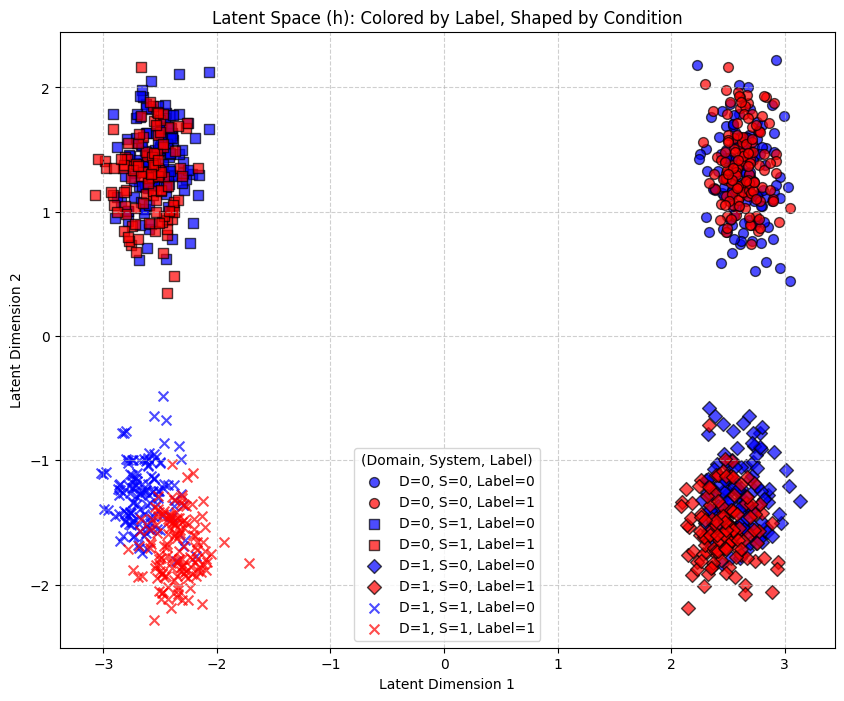

In [74]:
# --- 更新后的绘图逻辑 ---
plt.figure(figsize=(10, 8))

# 定义颜色对应 label，形状对应 (domain, system)
colors = {0: 'blue', 1: 'red'}
markers = ['o', 's', 'D', 'x'] # (D=0,S=0), (D=0,S=1), (D=1,S=0), (D=1,S=1)

# 将 domain 和 system 组合成一个唯一的 ID
combo_ids = all_d * 2 + all_s

# 遍历每一种 (domain, system) 和 label 的组合
for combo_id in range(4):      # 遍历4种 (D,S) 组合
    for label_id in range(2):  # 遍历2种 Label
        
        # 创建一个掩码，只选择当前组合的数据点
        mask = (combo_ids == combo_id) & (all_c == label_id)
        
        # 如果存在这样的数据点，则绘制它们
        if np.any(mask):
            domain_val = combo_id // 2
            system_val = combo_id % 2
            plt.scatter(all_h[mask, 0], all_h[mask, 1], 
                       c=colors[label_id],
                       marker=markers[combo_id],
                       edgecolors='k',
                       s=50,
                       alpha=0.7,
                       label=f'D={domain_val}, S={system_val}, Label={label_id}')

plt.title('Latent Space (h): Colored by Label, Shaped by Condition')
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend(title='(Domain, System, Label)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

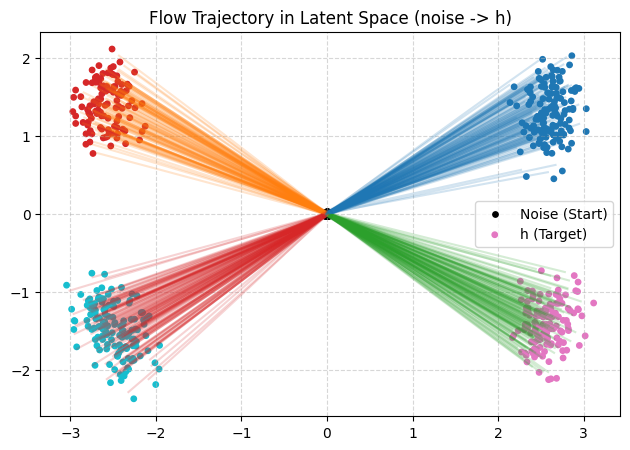

In [77]:
# c) 可视化Flow采样过程
test_samples_for_flow = 500
x_flow, d_flow, s_flow, _ = test_data[:test_samples_for_flow], test_d[:test_samples_for_flow], test_s[:test_samples_for_flow], test_y[:test_samples_for_flow]
x_flow, d_flow, s_flow = x_flow.to(device), d_flow.to(device), s_flow.to(device)

mu, log_var = model.encoder(x_flow, d_flow, s_flow)
h_targets = model.reparameterize(mu, log_var).detach()
z0_flow = torch.randn_like(h_targets)*0.01

# 采样轨迹
trajectories = [z0_flow.clone().unsqueeze(0)]
model.eval()
with torch.no_grad():
    for t_step in np.linspace(0, 1, 100):
        t = torch.full((test_samples_for_flow, 1), t_step).to(device)
        z_t = trajectories[-1].squeeze(0)
        v_pred = model.flow_net(z_t, t, h_targets)
        z_next = z_t + v_pred * (1.0/100.0) # dt = 1/100
        trajectories.append(z_next.unsqueeze(0))

trajectories_np = torch.cat(trajectories).cpu().numpy()
h_targets_np = h_targets.cpu().numpy()
combo_labels_flow = (d_flow * 2 + s_flow).cpu().numpy()

# 绘制流轨迹
plt.title('Flow Trajectory in Latent Space (noise -> h)')
for i in range(test_samples_for_flow):
    plt.plot(trajectories_np[:, i, 0], trajectories_np[:, i, 1], 
             color=plt.cm.tab10(combo_labels_flow[i]), alpha=0.2)

# 绘制起点和终点
plt.scatter(trajectories_np[0, :, 0], trajectories_np[0, :, 1], color='black', s=15, label='Noise (Start)')
scatter2 = plt.scatter(h_targets_np[:, 0], h_targets_np[:, 1], c=combo_labels_flow, cmap='tab10', s=15, label='h (Target)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
